In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cdist
import time
# import datetime
from datetime import datetime
import builtins
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import OPTICS
import sklearn as sk
import math 
# import sklearn.linear_model as slm (statsmodels gives more robust results)
# import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
import seaborn as sns #for nicer plots.
# from patsy import dmatrices
from pylab import rcParams

# import descartes
from shapely.geometry import Point, Polygon

# import geopandas as gpd
# from sklearn import cluster
from sklearn.preprocessing import scale
# import pysal as ps
from sklearn.metrics.pairwise import haversine_distances
from math import radians

# from geopy.distance import great_circle
from shapely.geometry import MultiPoint

# import cartopy
# import cartopy.feature as cfeature
# import cartopy.io.shapereader as shpreader
# import cartopy.io.img_tiles as cimgt
# import cartopy.crs as ccrs
# from cartopy.io.shapereader import Reader
# from cartopy.feature import ShapelyFeature
# from cartopy.io.shapereader import Reader
# from cartopy.feature import ShapelyFeature

import matplotlib.patheffects as PathEffects
from shapely.geometry import LineString, MultiLineString
# import cartopy.crs as ccrs
import io
from urllib.request import urlopen, Request
from PIL import Image
# import functions

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import pairwise_distances, davies_bouldin_score
from sklearn import datasets

from sklearn.cluster import KMeans


from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets

import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import scipy.interpolate as interp

from scipy.spatial.distance import cdist
from scipy.spatial import distance
from IPython.display import display
import sys
from pathlib import Path
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib
import geopandas as gpd
# import osmnx as ox
import seaborn as sns
# import gtfs_kit as gk
import dash
from dash.dependencies import Input, Output
import plotly.express as px
import timeit
import warnings
from tqdm import tqdm
import gtfs_kit as gk
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# %load_ext autoreload
# %autoreload 2
%matplotlib inline


pd.set_option("display.max.columns", 20)

plt.style.use({'figure.facecolor':'white'})
plt.rcParams['font.size'] = '18'
plt.rcParams['figure.figsize'] = (18, 7)

In [26]:
full_bytemark_path = r"../../data/raw/PVTA-Data-Sharing-UMass/Bytemark-Data/Full_202201_Umass.csv"
cleaned_stops_path = "../../data/raw/PVTA-Data-Sharing-UMass/APC-Data/Cleaned-Stop-Database.xlsx"
raw_pvta_data_path = "../../data/raw/PVTA-Data-Sharing-UMass/"
# route_stop_path = f"{raw_pvta_data_path}Route_Stop_Mx.csv"
data_path = "../../data/raw/PVTA-Data-Sharing-UMass/APC-Data/Ridership-Details_201807-201912.txt"
dictionary_path = "../../data/raw/PVTA-Data-Sharing-UMass/APC-Data/APC-Data-Dictionary-and-Sample.xlsx"
cleaned_stops_path = "../../data/raw/PVTA-Data-Sharing-UMass/APC-Data/Cleaned-Stop-Database.xlsx"

In [27]:
period = input('Which period:\n' # Settings
          '1: March-May\n'
          '2: June-July\n'
          "3: Jan-March\n"
          "4: Jan-2022\n"
          "5: dec-22-2021\n"
          "6: dec-14-2021\n")

# def load_data(path):
#     data = pd.read_csv(path)
#     return data

def used_bytemark(full_bytemark):
    print('Preparing the bytemark to use...')
    byte = full_bytemark.copy()
    # get bytemark in the same times as the timetable
    bytemark_sample_used = byte.loc[route_timetable_.Timestamp[0].strftime("%Y-%m-%d %H:%M:%S"):route_timetable_.Timestamp[-1].strftime("%Y-%m-%d %H:%M:%S")] #https://www.programiz.com/python-programming/datetime/strftime
    bytemark_sample_used = bytemark_sample_used.reset_index()

    bytemark_sample_used['Time_Scanned'] = bytemark_sample_used['Time_Scanned'].map(lambda x: x.lstrip('').rstrip('-04:00:00')) # removed the -04:00:00 part.
    bytemark_sample_used['Time_Scanned'] = bytemark_sample_used['Time_Scanned'].map(lambda x: x.lstrip('').rstrip('-05:00:00')) # removed the -05:00:00 part when daylight saving is in effect.

    bytemark_sample_used['Time_Scanned'] = pd.to_datetime(bytemark_sample_used['Time_Scanned'])

    bytemark_sample_used = bytemark_sample_used.set_index('Datetime')
    bytemark_sample_used = bytemark_sample_used.loc['2021-03-15':'2021-03-15']
    bytemark_sample_used = bytemark_sample_used.reset_index()

    return bytemark_sample_used


def load_all_data(full_bytemark_path, cleaned_stops_path, period ):

    print(f'Loading Bytemark...')
    full_bytemark = pd.read_csv(full_bytemark_path)
    full_bytemark['Datetime'] = full_bytemark.Time_Scanned.str[0:19]
    full_bytemark.Datetime = pd.to_datetime(full_bytemark.Datetime)
    full_bytemark['Hour'] = full_bytemark['Datetime'].dt.hour
    full_bytemark = full_bytemark.set_index('Datetime')
####################################################################################################################################
    print(f"Loading full_stops...")
    full_stops = pd.read_excel(cleaned_stops_path)
    full_stops = full_stops[full_stops['StopReportLabel'].notna()]
    full_stops = full_stops[full_stops['StopID'].notna()]
    full_stops = full_stops.drop(full_stops.index[0])
    full_stops = full_stops.reset_index()
    full_stops = full_stops.drop('index', axis=1)
    full_stops = full_stops[:-1]
    full_stops = full_stops [['StopID', 'StopReportLabel','UniqueStopInternalID','Latitude','Longitude','StopActiveDesc']]
####################################################################################################################################

    print(f"Loading bus schedule...")
    if period == '1':
        print('You chose March-May')
        path = '../../data/raw/PVTA-GTFS/gtfs-15-march-2021.zip'
        route_timetable = pd.read_csv(r"../../data/raw/PVTA-GTFS/route_timetable_March_May.csv",low_memory=False)
    elif period == '2':
        print('You chose June-August')
        path = '../../data/raw/PVTA-GTFS/gtfs-24-june-2021.zip'
        route_timetable = pd.read_csv(r"../../data/raw/PVTA-GTFS/route_timetable_June_August.csv",low_memory=False)
    elif period == '3':
        path = '../../data/raw/PVTA-GTFS/gtfs-26-jan-2021.zip'
        route_timetable = pd.read_csv(r"../../data/raw/PVTA-GTFS/route_timetable_Jan_March.csv",low_memory=False)
    elif period == '4':
        route_timetable = pd.read_csv(r"../../data/raw/PVTA-GTFS/route_timetable_Jan_2022.csv",low_memory=False)
    elif period == '5':
        route_timetable = pd.read_csv(r"../../data/raw/PVTA-GTFS/route_timetable_dec_22_2021.csv",low_memory=False)
    elif period == '6':
        route_timetable = pd.read_csv(r"../../data/raw/PVTA-GTFS/route_timetable_dec_14_2021.csv",low_memory=False)

    # Read gtfs feed and describe
    # get separate GTFS files
    feed = gk.read_feed(path, dist_units='km')
    stop_times = feed.stop_times
    trips = feed.trips
    routes = feed.routes
    gtfs_stops = feed.stops
    calendar = feed.calendar
    calendar_dates = feed.calendar_dates
    shapes = feed.shapes
    dates = feed.get_dates() # get a list of dates for which this GTFS is valid
####################################################################################################################################
    # CONTINUE PREPARING STOPS AFTER LOADING gtfs
    # full_stops = full_stops.loc[full_stops['StopActiveDesc'] == 'Active']
    stop_times.stop_id = stop_times.stop_id.astype('str') # find stops only in the schedule
    k = list (stop_times.stop_id)
    full_stops.StopID = full_stops.StopID.astype('int')
    full_stops.StopID = full_stops.StopID.astype('str')
    full_stops = full_stops[full_stops['StopID'].isin(k)]

    full_stops.StopID = full_stops.StopID.astype('float')
    full_stops.StopID = full_stops.StopID.astype('int')
    full_stops.StopID = full_stops.StopID.astype('str')
####################################################################################################################################

    ## prepare schedule data
    # For boarding inference
    route_timetable_ = route_timetable.copy() # original file loaded in the begining
    route_timetable_.departure_time = pd.to_timedelta(route_timetable_.departure_time)
    route_timetable_.date = pd.to_datetime(route_timetable_.date)
    route_timetable_.date = route_timetable_.date + route_timetable_.departure_time
    route_timetable_ = route_timetable_.rename(columns={"date": "Timestamp","stop_id":"StopID"})
    # route_timetable_= route_timetable_.set_index('Time_Stamp')
    route_timetable_.StopID = route_timetable_.StopID.astype('str')
    route_timetable_=route_timetable_.drop(columns = ['arrival_time','departure_time'])
    route_timetable_ = route_timetable_.sort_values('Timestamp')
    # route_timetable_.index.name = None
    # route_timetable_[(route_timetable_['Timestamp']>=pd.Timestamp(2021,7,1))& (route_timetable_['Timestamp']<pd.Timestamp(2021,8,1))]
    route_timetable_['date'] = route_timetable_.Timestamp.dt.date
    route_timetable_ = route_timetable_.set_index('date')

    # For alighitng inference
    route_timetable_alighting = route_timetable.copy() # original file loaded in the beginning
    # make departure time with date
    route_timetable_alighting.departure_time = pd.to_timedelta(route_timetable_alighting.departure_time)
    route_timetable_alighting['departure_date'] = pd.to_datetime(route_timetable_alighting.date)
    route_timetable_alighting.departure_date = route_timetable_alighting.departure_date + route_timetable_alighting.departure_time
    #
    # make arrival time with date
    route_timetable_alighting.arrival_time = pd.to_timedelta(route_timetable_alighting.arrival_time)
    route_timetable_alighting['arrival_date'] = pd.to_datetime(route_timetable_alighting.date)
    route_timetable_alighting.arrival_date = route_timetable_alighting.arrival_date + route_timetable_alighting.arrival_time

    route_timetable_alighting = route_timetable_alighting.rename(columns={"departure_date": "Timestamp","stop_id":"StopID"})
    route_timetable_alighting= route_timetable_alighting.set_index('Timestamp')
    route_timetable_alighting.StopID = route_timetable_alighting.StopID.astype('str')
    route_timetable_alighting=route_timetable_alighting.drop(columns = ['arrival_time','departure_time'])

    route_timetable_alighting.index.name = None
    route_timetable_alighting.to_csv(r"../../data/raw/PVTA-GTFS/route_timetable_alightingfor_transfer_inference.csv")#, index=False,)
    route_timetable_alighting
    # route_timetable_alighting
    route_timetable_alighting = pd.read_csv(r"../../data/raw/PVTA-GTFS/route_timetable_alightingfor_transfer_inference.csv",low_memory=False)
    route_timetable_alighting['arrival_date'] = pd.to_datetime(route_timetable_alighting.arrival_date)
    route_timetable_alighting['Unnamed: 0'] = pd.to_datetime(route_timetable_alighting['Unnamed: 0'])
    route_timetable_alighting= route_timetable_alighting.set_index('Unnamed: 0')
    route_timetable_alighting['StopID'] = route_timetable_alighting['StopID'].astype('str')
    print("Loading successful. \n Preparing stops and routes data...")
    # create stop routes
    stop_routes = route_timetable_alighting.copy(deep = True)
    stop_routes = stop_routes[['route_id','StopID']]
    stop_routes = stop_routes.drop_duplicates(keep='first')  # drops duplicate rows leaving behind all possible combinations
    tempstops = full_stops.copy(deep = True)
    tempstops = tempstops[['StopID','Latitude','Longitude','StopReportLabel','UniqueStopInternalID']]
    # display(stop_routes.dtypes)
    # display(tempstops.dtypes)
    tempstops.StopID =  tempstops.StopID.astype('str')
    stop_routes = stop_routes.merge(tempstops, on = 'StopID',how='inner')
    route_timetable_alighting_with_coords = route_timetable_alighting.merge(tempstops, on='StopID', how='inner')
####################################################################################################################################



    return full_bytemark,full_stops, route_timetable_, route_timetable_alighting_with_coords, stop_routes,route_timetable


full_bytemark , full_stops, route_timetable_, route_timetable_with_coords, stop_routes,route_timetable = load_all_data(full_bytemark_path, cleaned_stops_path, period, )
# route_timetable_with_coords is for alighiting inference

bytemark_sample_used = used_bytemark(full_bytemark)

print('Done!')

Loading Bytemark...
Loading full_stops...
Loading bus schedule...
Loading successful. 
 Preparing stops and routes data...
Preparing the bytemark to use...
Done!


In [28]:
routes = stop_routes.copy()
routes['Num_of_stops']= 1
routes.groupby(['route_id']).sum() # gives number of stops per route

,Latitude,Longitude,UniqueStopInternalID,Num_of_stops
route_id,,,,
30,1695.191527,-2900.499864,316803,40
31,2077.720328,-3554.284462,383258,49
33,2077.236815,-3553.692225,391941,49
34,1144.511626,-1958.168452,213404,27
35,1144.507672,-1958.165163,220497,27
36,1313.470504,-2248.136039,251190,31
38,1904.649789,-3264.102185,351196,45
45,2583.480775,-4420.996716,486090,61
46,848.741318,-1451.211608,165297,20


In [29]:
# route_stop = load_data(route_stop_path)
# route_stop.set_index('Unnamed: 0', inplace=True)
# route_stop.index.name = 'stop_id'
# print(((len(full_stops) - len(full_stops.loc[full_stops['StopActiveDesc'] == 'Active']) )/ len(full_stops))*100, '% of the full_stops are inactive at the moment. The inference will only be done on the active full_stops which may reduce accuracy due the the stop being active at the time of activation')

# use GTFS kit
## use timetable for inference (has date, trip id, routes, stops, and arrival times)

In [30]:
# get separate GTFS files
# feed = gk.read_feed(path, dist_units='km')
# stop_times = feed.stop_times
# trips = feed.trips
# routes = feed.routes
# gtfs_stops = feed.stops
# calendar = feed.calendar
# calendar_dates = feed.calendar_dates
# shapes = feed.shapes

# Boarding inference
###### flow:
###### for every activation in Bytemark:
######     -filter stop_times file to get only the stops used around the activation time
######     -take those stop names and filter the full stops file to get those stops lon lat
######     -check the proximity of the activation to this list of stops
######     -assign to the stop within threshold

###### Prepare the data:
###### Load GTFS stop_times file (old)
###### use the route_timetable_ instead (has everything in stop_times file and more)
###### prepare route_timetable_ file

## Prepare the Bytemark sample that will be used
#### Bytemark for the specified GTFS period
##### Get dates from route timetable and subset the bytemark to the date range to have a valid inference.
###### This is with the purpose of eventually inferring the alightings for every period so no need to get a perect month from 1 to 31

# Use a week to get results for better assumptions faster
## use full data for the spatial analysis

###### Filter stops to only contain the stops which are in the GTFS stop times folder for that period(the GTFS period) (as passengers couldn't have used a stop which is not in the schedule for that period of time( avoids false inferences and also avoids an error later when we try to find the route ID for the inferred stop in the GTFS file and it's not there))
###### Seems like some stops are missing in the GTFS. Leave these in for now

In [31]:
# stop_times.stop_id = stop_times.stop_id.astype('str')
# k = list (stop_times.stop_id)
# full_stops.StopID = full_stops.StopID.astype('int')
# full_stops.StopID = full_stops.StopID.astype('str')
# full_stops = full_stops[full_stops['StopID'].isin(k)]
# full_stops

#### This next part will need to be removed later (removed)
###### The "route_stop_undummied" file sent by PVTA (Am's email) does not contain all the stops. I will have to remove those stops from all the files to make this work. (fix)
###### Does the route file contain stopID or unique IDs? ( use stop ID)
###### So:
###### "route_stop_undummied" (which is made in the next cell) will be used to infer boarding stops instead of the full stops file above so we don't infer a stop from "full_stops" that is not found when we try to find the possible routes from the "route_stop_undummied " file
###### {"route_stop_undummied" contains the stops and their routes and merged with full stops to contain other info}

###### First remove the duplicated stop ids in the boarding inference (due to multiple routes for each one). we only need one stop and its location in this first step (is this when we only used the first route as the correct one? If so, remove this line)

###### The next functions will use the full data to include all possibilities of routes for each inferred stop here

###### Useful idea to get the trip ID along with the stop id (no need to find all possible ids later)

###### Code alternative to the joining method below (df = df.groupby(['stop id','info'])['trip id'].apply(', '.join).reset_index()) (grouping by all other columns and then applying the join function)

### The code below infers the boarding stop id, unique stop id, and possible trip ids.

Failed
- tqdm was messing with the index value (fix by separating tqdm and the for loop)
- the bytemark starts at the same date but not the same hour of the timetable (fixed by adding an hour to the above code that matches the dates)

## A week from march 15th to 21st to test the thresholds, changes save file to a week temporarily. Change it back later

## 1: get UUIDS and cluster labels from 11.7.2.1 and subset the current data by tyopology and make a table of the accuracy for each.
## 2: concat them and save file

    - Changed naming of saved files in jan march inside function. Turn back


Define the functions

## Next set Global to False and set thresholds

In [32]:
def merge_data_and_clusterlabels(bytemark = bytemark_sample_used):
    """

    :param bytemark: The bytemark intended to be comlemented with cluster labels
    :return: bytemark with labels
    """
    bytemark.UUID = bytemark.UUID.astype('str')
    uuid_and_labels = pd.read_parquet('dataframes/uuid-cluster-labels-from-st-analysis.parquet')
    bytemark_clustered = pd.merge(bytemark,uuid_and_labels,on='UUID')
    return bytemark_clustered

def closest_point(point, points, threshold):
    """
    Calculates the distance between the activation location and all stops in the system. Returns the closest stop location and the index of that stop to be used to bring other information from the temp folder used in the calculation.

    :param point: The activation coordinates in a tuple form.
    :param points: All stop coordinates in a list of tuples. The stops are filterd first by schedule.
    :param threshold: The distance within which we want to find stops around the activation location. It is a euclidean distance and in this area 0.01 is approximately equal to 1 km.
    :return: The closest stop location and the index of that stop.
    """
    if points:
        # Find closest point from a list of points.
        # filter to not take anything more that a certain euclidean distance (0.001 roughly equals 100 meters)
        euclidean = cdist([point], points)

        euclidean_s = euclidean[np.where(euclidean < threshold)] # test different combinations of these thresholds and document # 0.01 is 1 km
        if euclidean_s.size:
        # if True:
            #slight caveat. if you dont use euclidean_s as it is used above, it takes the index from the shortened list and compares it the the full list of the full_stops (fixed by using euclidean_s as a separate stipulation for making the inference)
            ind = euclidean.argmin() #index of smallest value

            return points[ind],ind # uses index of minimum distance in the list between a 'point' and 'points' to get the lon lat from 'points' list
        else:
            return 9999999,9999999 # 9999999 in the assigned stop location column means it does not meat the distance threshold requirement
    else:
        return 9999999,9999999

def determine_thresholds(Global_threshold,i):
    """
    Set a global or a more specific thresholds

    Set a time buffer (will it change based on typology too?)

    :return: threshold, buffer
    """

    if Global_threshold == True:
        threshold = 0.01 # global distance threshold
    elif i == 0:
        threshold = 0.0031 # 0.01 is 1 km
    elif i == 1:
        threshold =  0.00268
    elif i == 2:
        threshold = 0.0025
    elif i == 3:
        threshold = 0.0025
    buffer = 10 # minutes

    return threshold, buffer

def filter_timetable(route_timetable_,mini,maxi,Stops,):
                    """
                    Filters the timetable (schedule) dataframe to obtain only the stops used around the activation time and their route and trip IDs

                    The returned dataframe will be used as the stops data. The closest stop to the activation with the time threshold used here will be considered the boarding location.

                    issues:
                        if the stop closest to the activation location (e.g. across the street) has been used within the 40 minutes. It will be inferred. No way to fix.
                        This assigns Timestamp when grouping by stop ID to get possible routes and assumes that the multiple trips are on the same time. This is not true but wont affect the results (fix)

                    :param route_timetable_: Bus schedule.
                    :param mini: Lower bus arrival threshold. This accounts for the bas being late.
                    :param maxi: Higher bus arrival threshold. This accounts for the bus being early (such as buses arriving at end of line and waiting for 10 minutes to move while allowing passengers on).
                    :param Stops: All stops in the system. Used to add stop information such as location to the bus schedule data.
                    :return: temp: the possible stops and routes within the time threshold (has the stop, route, and trip IDs associated with each stop)
                             new: a dataframe with columns for each possible route
                    """

                    temp = route_timetable_.copy()
                    temp = temp[temp.Timestamp.between(mini, maxi)] # timetable of stops only used around the time of activation
                    temp = pd.merge(Stops, temp, how ='inner', on = 'StopID')# merged with the full stops file to get stops information in the filtered schedule
                    # The above merging results in identical rows with different route IDs for stops that have multiple possible trips with multiple or the same route
                    # The following code groups all identical columns and puts each possible trip id for the same stop in different columns with incremental values (trip 0, trip 1, etc.)
                    temp = temp.groupby('StopID').agg({'StopReportLabel':'first','UniqueStopInternalID':'first','Latitude':'first','Longitude':'first', 'StopLocation':'first','route_id': ', '.join, 'trip_id': ', '.join, 'Timestamp': 'first'}).reset_index() # 'trip_id': ', '.join,
                    # return temp,0
                    new = temp["route_id"].str.split(", ", n = 0, expand = True) # split possible route IDs for each station # gives a dataframe with columns for each possible route
                    # Add each of them to a different column
                    index_, no_of_route_columns= 0,0
                    for column in new:
                        suffix = '_No_' + str(index_)
                        col_name="route_id" + suffix
                        temp[col_name] = new[index_]
                        # del new
                        index_ += 1
                        no_of_route_columns += 1

                    # Drop the column with all of the IDs joined
                    temp.drop(columns =["route_id"], inplace = True)

                    # split possible trip IDs for each station # same thing as with routes
                    new_ = temp["trip_id"].str.split(", ", n = 0, expand = True)
                    # Add each of them to a different column
                    index_ = 0
                    for column in new_:
                        suffix = '_No_' + str(index_)
                        col_name="trip_id" + suffix
                        temp[col_name] = new_[index_]
                        # del new_
                        index_ += 1
                    # Drop the column with all of the IDs joined
                    temp.drop(columns =["trip_id"], inplace = True)

                    return temp, new

def assign_points_to_closest_stop_with_gtfs(full_stops,bytemark,route_timetable_, Global_threshold = True):
    """
    Infers the boarding stop id, unique stop id, and possible trip ids for each activation. Then returns a data frame with the inferred boarding stop, based on location and bus schedule, and all possible route IDs based on the bus schedule.

    :param full_stops: Dataframe of all stops in the network containing all information related to them including locations, labels, IDs, etc. Will be used to find closest stops to each activation.
    :param bytemark: Bytemark data frame that contains activation information such as location and timestamp.
    :param route_timetable_: Dataframe created from GTFS using GTFS_kit. It contains all bus schedules in the network including the trip IDs, route IDs, etc. Will be used to link activation times to bus arrival times at the closest stops to the activation.
    :return: 1. accuracy: List of accuracies of inference for each typology.
             2. dataframes: List of inferred data frames for each typology to be combined later.
    """

    accuracy = [] # record all typology accuracies here
    dataframes = [] # record all processed typologies here

    bytemark = merge_data_and_clusterlabels(bytemark = bytemark) # add typology labels (currently stop at March 2021)
    full_stops = full_stops.drop_duplicates(subset=['StopID'],keep='first') # REMOVE DUPLICATE STOPS. WE ONLY NEED THEM ONCE
    df1 = full_stops.copy()
    df1['StopLocation'] = [(x, y) for x,y in zip(df1['Latitude'], df1['Longitude'])]

    for i in range(bytemark.Typology.nunique()): # subset bytemark by typology
        Typology_num = i + 1
        print(f'FOR TYPOLOGY {Typology_num}')
        temp_bytemark = bytemark[bytemark.Typology == Typology_num]

        df2 = temp_bytemark.copy()
        df2['ActivationLocation'] = [(x, y) for x,y in zip(df2['Latitude'], df2['Longitude'])]
        # Create new column for inference
        df2['AssignedStopLonLat'] = np.nan
        df2['assigned_boarding_time'] = np.nan
        df2['UniqueStopInternalID'] = np.nan
        df2['StopID'] = np.nan
        df2.AssignedStopLonLat = [(9999999,9999999)] * len(df2) # Pandas wont set a tuple over any other value and returns an error. It does, however, set tuples over other tuples. That's why I made the new column a list of tuples (9999999,9999999).

        ## Set global or a more specific thresholds
        threshold,buffer = determine_thresholds(Global_threshold,i)
        print(f'the distance threshold is set to be {threshold * 100000} m and the time is {buffer} minutes')

        # use double return as in the alighting function to infer the location and the stop ID and maybe more all at once. yOU WONT NEED THE NEXT (match_value) FUNCTION. ? investigate what this means later. the closest_point function was directly below this text and  has been moved outside this function.

        with tqdm(total=len(df2)) as pbar: # explicit use of tqdm since using it in the for loop seems to change the index value unexpectedly
            for index, row in df2.iterrows(): # iterate through the bytemark rows
                pbar.update(1)
                # get the lower and upper time thresholds thresholds for each activation
                mini = pd.to_datetime([df2.loc[index,'Time_Scanned'] - pd.Timedelta(minutes = buffer)])
                mini = mini.astype('str')[0]
                maxi = pd.to_datetime([df2.loc[index,'Time_Scanned'] + pd.Timedelta(minutes = buffer)])
                maxi = maxi.astype('str')[0]

                temp,new = filter_timetable(route_timetable_,mini,maxi,Stops = df1,) # temp is the possible stops and routes within the time threshold (has the stop, route, and trip IDs associated with each stop) # new is a dataframe with columns for each possible route

                if temp.empty:  # if temp is empty (meaning no stop has been used around the time off activation, assign the stop to 9999999
                    df2['AssignedStopLonLat'][index] = 9999999 # assign the stop as 9999999 instead of (9999999,9999999) to signal it has been processed but no close stops exist

                else:  # In case stops have been used, check the proximity of the activation to this list of stops and assign to the closest stop within threshold
                    closest_point_, index_in_temp = closest_point(row['ActivationLocation'], list(temp['StopLocation']), threshold)
                    df2['AssignedStopLonLat'][index] = closest_point_  # assign the stop as the closest found in the filtered schedule data. If no stops have been found around the activation. assign stop as 9999999

                    if index_in_temp != 9999999: # If stops around the activation exist. Assign additional stop features other than the coordinates, such as the ID
                        df2['UniqueStopInternalID'][index], df2['StopID'][index]= temp['UniqueStopInternalID'][index_in_temp], temp['StopID'][index_in_temp] # puts the value in the bytemark in the current activation row as the value in the schedule data in the inferred stop row
                        df2['assigned_boarding_time'][index] = temp['Timestamp'][index_in_temp] #inaccurate (see the filter_timetable function description)
                        # add possible route and trip ids to the bytemark data this time
                        index_ = 0
                        for column in new: # new instead of temp since new has the index numbers we need (0,1,2,3,...) and same number of rows (could be because we dont want to reset temp index)
                            suffix = '_No_' + str(index_)
                            col_name="route_id" + suffix
                            if col_name not in df2: # add the column to the bytemark as a nan value if it does not exist. So, this assures columns are not duplicated with each new row processed.
                                df2[col_name] = np.nan
                            df2[col_name][index] = temp[col_name][index_in_temp] #After making sure the appropriate column exists, take possible route and trip ID from the schedule data and put them in the bytemark data
                            # Add trip IDs # Go back and split trip IDs (should be already done...?)
                            col_name_ = "trip_id" + suffix
                            if col_name_ not in df2:
                                df2[col_name_] = np.nan
                            # if the column exists, this step should work just fine
                            df2[col_name_][index] = temp[col_name_][index_in_temp]
                            index_ += 1
                del temp # save memory and run faster (should)
                del new
                del mini
                del maxi
                # del
        Number_of_points = len(df2) # for accuracy measures
        df2["AssignedStopLonLat"].replace({9999999: np.nan}, inplace=True) #Replace processed activations without results to nan leaving the tuples for later processing.
        df2.drop(columns =["Serial",'Price','Program','Weekday','Minute','Purchased','First_Activation','Expiration'], inplace = True)
        df2 = df2[df2['StopID'].notna()] # remove all uninferred activations

        ### clean data and rename dataframe?
        ########### get infeasible stops
        # df2.to_csv(r"../../data/tidy/Byte-April-inferred-uninferred-boarding.csv", index=True,)
        # temp__ = df2.copy()
        # full_bytemark = temp__[temp__['StopID'].isna()]
        # full_bytemark.to_csv(r"../../data/tidy/Byte-April-uninferred-boarding.csv", index=True,) (when you need uninferred)
        ###########

        # df2.dropna(subset = ["AssignedStopLonLat"], inplace=True) # Don't think this is necessary since we dropped the nan STOP IDs
        # print('Percentage of preliminary (before cleaning) matched boardings:',(len(df2)/Number_of_points)*100,'%') # calculate the matching rate for the typology

        # if period == '1':
        #     print('You chose March-May')
        #     df2.to_csv(f"../../data/tidy/Byte-April-inferred-boarding.csv", # turn to April
        #                           index=True,)
        # elif period == '2':
        #     print('You chose June-August')
        #     df2.to_csv(f"../../data/tidy/Byte-July-inferred-boarding.csv", # turn to April
        #                           index=True,)
        # elif period == '3':
        #     df2.to_csv(f"../../data/tidy/Byte-jan-march-2021-boarding-t{i+1}.csv", # turn to April
        #                           index=True,) # save to a week temporarily
        #
        #     # df2.to_csv(r"../../data/tidy/Byte-jan-march-2021-boarding.csv", # turn to April
        #                           # index=True,)
        # elif period == '4':
        #     df2.to_csv(f"../../data/tidy/Byte-jan-2022-inferred-boarding.csv", # turn to April
        #                           index=True,)
        # elif period == '5':
        #     df2.to_csv(f"../../data/tidy/Byte-dec-22-2022-inferred-boarding.csv", # turn to April
        #                           index=True,)
        # elif period == '6':
        #     df2.to_csv(f"../../data/tidy/Byte-dec-14-2022-inferred-boarding.csv",index=True)

        dataframes.append(df2) #each inferred T
        accuracy.append((len(df2)/Number_of_points)*100) #accuracies for each T
        del df2 # remove the data with this typology and start the next one in the for loop

    return accuracy,dataframes #, full_bytemark


## Use the function to process data with a very high distance threshold by setting Global = True below and then False when you reach the values
 - Keep in mind the accuracy wil be 5% higher than when you choose the p95 later

In [33]:
# choice = input(f'Would you like to start with global thresholds or obtimized ones?\n'
#                f'Global = 1\n'
#                f'Optimized = 0')
# Global = True if choice == 1 else False # test this code first
Global = True

start = time.time()
accuracy,dataframes = assign_points_to_closest_stop_with_gtfs(full_stops,bytemark_sample_used,route_timetable_, Global_threshold = Global) # ONLY RUN THIS FOR NEXT GTFS USAGE. Took 8011 seconds (2.225 hours) to run for March 11 - May 8 (50,000 rows)
end = time.time()

# Create the completed inferred file and save it then calculate the accuracy
full_assigned = pd.concat(dataframes)
Accuracy = (len(full_assigned)/len(bytemark_sample_used)) * 100
full_assigned.to_csv(f"../../data/tidy/Byte-15-march-2021-inferred-boarding.csv", index=False)
print(f'Time = {end - start},\n The result has an accuracy of {round(Accuracy)}% \n ')
display(full_assigned.head())

FOR TYPOLOGY 1
the distance threshold is set to be 1000.0 m and the time is 10 minutes


100%|██████████| 459/459 [01:15<00:00,  6.12it/s]


FOR TYPOLOGY 2
the distance threshold is set to be 1000.0 m and the time is 10 minutes


100%|██████████| 696/696 [01:53<00:00,  6.12it/s]


FOR TYPOLOGY 3
the distance threshold is set to be 1000.0 m and the time is 10 minutes


100%|██████████| 282/282 [00:45<00:00,  6.14it/s]


FOR TYPOLOGY 4
the distance threshold is set to be 1000.0 m and the time is 10 minutes


100%|██████████| 113/113 [00:18<00:00,  6.09it/s]

Time = 253.37192153930664,
 The result has an accuracy of 85% 
 


,Datetime,UUID,Faretype,Time_Scanned,Latitude,Longitude,Date,Calendar_Month,Hour,Status.x,...,route_id_No_6,trip_id_No_6,route_id_No_7,trip_id_No_7,route_id_No_8,trip_id_No_8,route_id_No_9,trip_id_No_9,route_id_No_10,trip_id_No_10
6,2021-03-15 04:55:43,679,7 Day Pass,2021-03-15 04:55:43,42.106557,-72.597563,3/15/2021,3,4,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2021-03-15 05:07:57,679,7 Day Pass,2021-03-15 05:07:57,42.106497,-72.594146,3/15/2021,3,5,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2021-03-15 10:29:27,679,7 Day Pass,2021-03-15 10:29:27,42.142034,-72.491949,3/15/2021,3,10,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,2021-03-15 05:11:28,2326,31 Day Regular,2021-03-15 05:11:28,42.091452,-72.580245,3/15/2021,3,5,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2021-03-15 15:19:32,2326,31 Day Regular,2021-03-15 15:19:32,42.142448,-72.543351,3/15/2021,3,15,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Global:  Time = 2292.4
         Accuracy = 86%
Special: Time = 1960
         Accuracy = 80%

highest accuracy is in T1  96% and lowest in T4 66% with the global thresholds
highest accuracy is in T1  90% and lowest in T4 62% with the special thresholds

In [34]:
print(accuracy) # highest in T1  94% and lowest T4 79% with the global thresholds

[94.11764705882352, 92.95977011494253, 84.04255319148936, 78.76106194690266]


## Optimized code (only run this when you need optimized speed with better thresholds
# Use this code later when you confirm the best numbers to adjust the above code

--------------------------------------------------------------------
# Can now run time analysis since we can use the Time of boarding as the bus schedule and time of activations as the bus arrival
# To do analysis on results without going through runnung the code. load any data file that you already used the global threshold (> 1000 m) on.

# Distribution of distances from all assigned activation locations to their assigned (the thresholds are 1 km and 20 minuutes)

In [35]:
from math import sqrt
full_assigned = pd.read_csv(f"../../data/tidy/Byte-15-march-2021-inferred-boarding.csv") # Accuracy = 85 in the latest run.

def calc_distance(p1, p2): # simple function to find euclidean distance between two coordinate tuples
  return sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2) # Pythagorean theorem
# calc_distance((42.10634936, -72.59711681),(42.106392, -72.594678))*100000/1.15 # gives meters. If you want miles use: (0.000621371 * (100000/1.15))

full_assigned['dist'] = np.nan
for index, row in full_assigned.iterrows():
    closest_point_ = calc_distance(eval(row['ActivationLocation']), eval(row['AssignedStopLonLat'])) # use eval when you load the data because tuples become strings. eval reverts it
    full_assigned['dist'][index] = closest_point_ * (5280 * 0.000621371 * (100000/1.15)) # only works for this local area since were using euclidean distance. Change to greater circle.
full_assigned.head()

,Datetime,UUID,Faretype,Time_Scanned,Latitude,Longitude,Date,Calendar_Month,Hour,Status.x,...,trip_id_No_6,route_id_No_7,trip_id_No_7,route_id_No_8,trip_id_No_8,route_id_No_9,trip_id_No_9,route_id_No_10,trip_id_No_10,dist
0,2021-03-15 04:55:43,679,7 Day Pass,2021-03-15 04:55:43,42.106557,-72.597563,3/15/2021,3,4,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,824.472497
1,2021-03-15 05:07:57,679,7 Day Pass,2021-03-15 05:07:57,42.106497,-72.594146,3/15/2021,3,5,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.684523
2,2021-03-15 10:29:27,679,7 Day Pass,2021-03-15 10:29:27,42.142034,-72.491949,3/15/2021,3,10,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.729083
3,2021-03-15 05:11:28,2326,31 Day Regular,2021-03-15 05:11:28,42.091452,-72.580245,3/15/2021,3,5,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.569903
4,2021-03-15 15:19:32,2326,31 Day Regular,2021-03-15 15:19:32,42.142448,-72.543351,3/15/2021,3,15,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342.626080


##### full_assigned.to_csv(f"../../data/tidy/Byte-week-march-2021-inferred-boarding_for_analysis.csv", index=False) # use to analyze the data for a week

FOR TYPOLOGY 1
mean 269.5450433343701
95th percentile: 1026.2420748819418
median 133.13710717500555
mode 0    103.019621
Name: dist, dtype: float64
FOR TYPOLOGY 2
mean 246.78311904423367
95th percentile: 1132.5538126034091
median 117.22330357975439
mode 0    120.606105
Name: dist, dtype: float64
FOR TYPOLOGY 3
mean 269.466694131874
95th percentile: 1193.5735477108183
median 130.5810812791302
mode 0    28.123264
1    70.320365
Name: dist, dtype: float64
FOR TYPOLOGY 4
mean 136.9740553698728
95th percentile: 497.93919900975453
median 80.79110060818256
mode 0    16.890585
Name: dist, dtype: float64


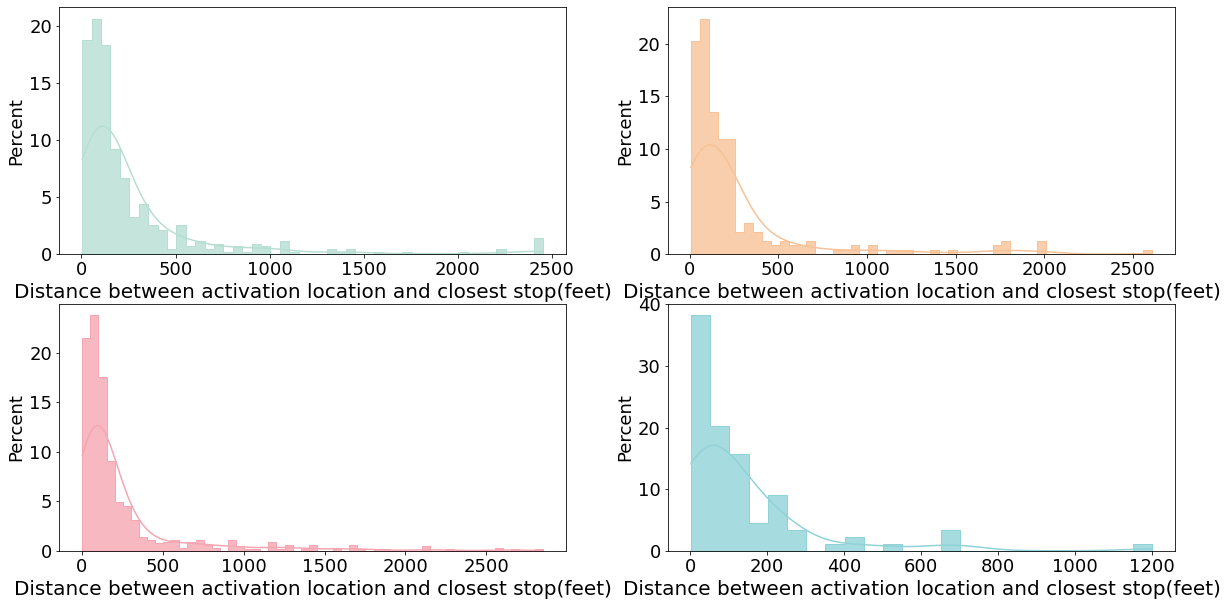

In [36]:
# full_assigned.to_csv(f"../../data/tidy/Byte-week-march-2021-inferred-boarding_for_analysis.csv", index=False) # use to analyze the data for a week
# full_assigned = pd.read_csv(f"../../data/tidy/Byte-week-march-2021-inferred-boarding_for_analysis.csv")
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharey=False)

j = 0
x = 0
# color = ['#f0e594','#57b884','#ffab8d','#ff6a9e'] # SNS color palette
color = ['#b7ded2','#f6a6b2','#f7c297','#90d2d8'] # carnival vintage Color Palette
for i in range(4):
    print(f'FOR TYPOLOGY {i+1}')
    typology = full_assigned[full_assigned.Typology == i + 1]
    print(f'mean {typology.dist.mean()}')
    print(f'95th percentile: {np.percentile(typology.dist, 95)}')
    print(f'median {typology.dist.median()}')
    print(f'mode {typology.dist.mode()}')
    if i == 1:
        x = 1
        j = 0
    if i == 2:
        x = 0
        j = 1
    if i == 3:
        x = 1
        j = 1
    g = sns.histplot(data = typology
                ,x = 'dist'
                # ,color = 'navy'
                ,alpha = 0.8
                     ,stat='percent'
                # ,bins = 50
                 ,binwidth = 50
                 ,kde = True
                     ,element = 'step'
                 # ,hue = 'Typology'
                 # , palette= 'tab10'
                 , color=color[i],
                 ax=ax[x][j]
                )#.set_xlim(0, 0.25)
    g.set_xlabel("Distance between activation location and closest stop(feet)", fontsize = 20)


# Time analysis
- change time threshold as well and calculate efficieny increase
- Next go streamline the alighting inference

In [37]:
# Convert to datetime first
full_assigned[['Time_Scanned','assigned_boarding_time']] = full_assigned[['Time_Scanned','assigned_boarding_time']] .apply(pd.to_datetime)
# make time difference column between activation and scheduled bus arrival
full_assigned['diff'] = (full_assigned.Time_Scanned - full_assigned.assigned_boarding_time).astype('timedelta64[m]') # m = minutes
full_assigned.dtypes

Datetime                          object
UUID                               int64
Faretype                          object
Time_Scanned              datetime64[ns]
Latitude                         float64
Longitude                        float64
Date                              object
Calendar_Month                     int64
Hour                               int64
Status.x                          object
ED                                  bool
Typology                           int64
ActivationLocation                object
AssignedStopLonLat                object
assigned_boarding_time    datetime64[ns]
UniqueStopInternalID             float64
StopID                             int64
route_id_No_0                     object
trip_id_No_0                      object
route_id_No_1                     object
trip_id_No_1                      object
route_id_No_2                     object
trip_id_No_2                      object
route_id_No_3                     object
trip_id_No_3    

# Find percentile above and below zero separately

All usage will be within the chosen threshold which is arguably more accurate the lower the threshold. and the 95th percentile will always be near the max because the algorithm chooses the closest stop used. not the closest in time. Fix this by considering time closeness as well as distance in the main algorithm.

FOR TYPOLOGY 1
mean 0.2708333333333333
 + 95th percentile: 9.0
 - 95th percentile: 10.0
median 1.0
mode 0    1.0
Name: diff, dtype: float64
FOR TYPOLOGY 2
mean 0.973724884080371
 + 95th percentile: 9.0
 - 95th percentile: 9.0
median 1.0
mode 0   -1.0
1    0.0
Name: diff, dtype: float64
FOR TYPOLOGY 3
mean 1.3924050632911393
 + 95th percentile: 9.0
 - 95th percentile: 9.0
median 2.0
mode 0    3.0
Name: diff, dtype: float64
FOR TYPOLOGY 4
mean 1.4157303370786516
 + 95th percentile: 9.0
 - 95th percentile: 8.7
median 1.0
mode 0    4.0
Name: diff, dtype: float64


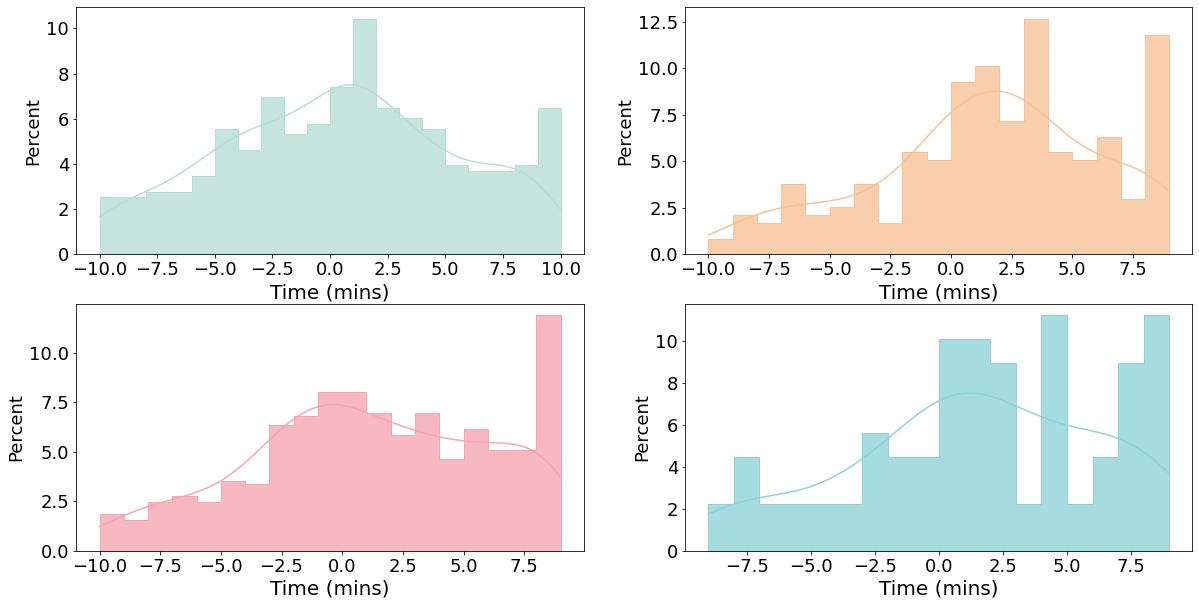

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharey=False) #sharey and sharex for sharing same axis

j = 0
x = 0
# color = ['#f0e594','#57b884','#ffab8d','#ff6a9e'] # SNS color palette
color = ['#b7ded2','#f6a6b2','#f7c297','#90d2d8'] # carnival vintage Color Palette
for i in range(4):
    print(f'FOR TYPOLOGY {i+1}')
    typology = full_assigned[full_assigned.Typology == i + 1]
    print(f'mean {typology["diff"].mean()}')
    print(f' + 95th percentile: {np.percentile(typology[typology["diff"] > 0]["diff"], 95)}')
    print(f' - 95th percentile: {np.percentile(-1 * typology[typology["diff"] < 0]["diff"], 95)}')
    print(f'median {typology["diff"].median()}')
    print(f'mode {typology["diff"].mode()}')
    if i == 1:
        x = 1
        j = 0
    elif i == 2:
        x = 0
        j = 1
    elif i == 3:
        x = 1
        j = 1
    g = sns.histplot(data = typology
                ,x = 'diff'
                # ,color = 'navy'
                ,alpha = 0.8
                     ,stat='percent'
                # ,bins = 50
                 ,binwidth = 1
                 ,kde = True
                  ,element = 'step'
                 # ,hue = 'Typology'
                 # , palette= 'tab10'
                 , color=color[i],
                 ax=ax[x][j]
                )#.set_xlim(0, 0.25)
    g.set_xlabel("Time (mins)", fontsize = 20)

Go back and adjust thresholds. Then start the ...

--------------------------------------------------------------
# Alighting inference

In [39]:
Boardings_data = full_assigned.copy()
boarding_sample = Boardings_data.drop(columns = ['Faretype','UniqueStopInternalID']).copy()
num = len(boarding_sample)
Boardings_data

,Datetime,UUID,Faretype,Time_Scanned,Latitude,Longitude,Date,Calendar_Month,Hour,Status.x,...,route_id_No_7,trip_id_No_7,route_id_No_8,trip_id_No_8,route_id_No_9,trip_id_No_9,route_id_No_10,trip_id_No_10,dist,diff
0,2021-03-15 04:55:43,679,7 Day Pass,2021-03-15 04:55:43,42.106557,-72.597563,3/15/2021,3,4,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,824.472497,-5.0
1,2021-03-15 05:07:57,679,7 Day Pass,2021-03-15 05:07:57,42.106497,-72.594146,3/15/2021,3,5,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.684523,7.0
2,2021-03-15 10:29:27,679,7 Day Pass,2021-03-15 10:29:27,42.142034,-72.491949,3/15/2021,3,10,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.729083,-3.0
3,2021-03-15 05:11:28,2326,31 Day Regular,2021-03-15 05:11:28,42.091452,-72.580245,3/15/2021,3,5,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.569903,-7.0
4,2021-03-15 15:19:32,2326,31 Day Regular,2021-03-15 15:19:32,42.142448,-72.543351,3/15/2021,3,15,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342.626080,-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,2021-03-15 19:31:45,6523,One Ride,2021-03-15 19:31:45,42.088028,-72.568598,3/15/2021,3,19,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.890585,8.0
1401,2021-03-15 19:32:15,6523,One Ride,2021-03-15 19:32:15,42.088028,-72.568598,3/15/2021,3,19,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.890585,9.0
1402,2021-03-15 19:32:28,6523,One Ride,2021-03-15 19:32:28,42.088028,-72.568598,3/15/2021,3,19,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.890585,9.0
1403,2021-03-15 20:29:29,3802,One Ride,2021-03-15 20:29:29,42.169242,-72.640587,3/15/2021,3,20,EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.470560,-6.0


# Clean boarding data from false activations and single activations (unfinished)
- says 36% are single activations
    - Activations showing up once
    - Repeated activations at the same stop
    - Last activations at the first activations stops (assuming last destination is the same as first origin, these must be removed)

In [40]:
byte_with_no_single_acts = []
day = 0
num = 0
total = 0
days = boarding_sample.Date.nunique()
for date in boarding_sample.Date.unique():
    print(date)
    day += 1
    print('Day', day,'of',days)
    temp_ = boarding_sample[(boarding_sample['Date'] == date)] # subset by days

    for uuid in tqdm(temp_.UUID.unique()): # Subset by user
        # pbar.update(1)
        temp = temp_[(temp_['UUID'] == uuid)]
        if len(temp)> 1: # Check if more than one activation in a day
            #shift to get next activations
            x = len(temp)
            temp = temp.loc[temp.StopID.shift(-1) != temp.StopID] # this solves the issue of boarding from a stop to the same stop being inferred in case the there are not only two trips in the day which are inferred to the same stop
            y = len(temp)
            num+= (x-y) #Repeated activations at the same stop
            temp["NextBoardingStop"]= temp["StopID"].shift(-1)
            temp['NextBoardingStop'].iloc[-1] = np.array(temp.StopID.head(1))[0] # Assign last destination as first origin
            temp["NextBoardingTimeScanned"]= temp["Time_Scanned"].shift(-1)
            temp['NextBoardingTimeScanned'].iloc[-1] = pd.NaT # assign as a 'NOT A TIME' value for last destination of the day (not even a needed value since this is only treated as the last destination, not an actual next boarding stop)
            # display(temp[['StopID','NextBoardingStop','NextBoardingTimeScanned']])
            if len(temp) < 2:
                temp.NextBoardingStop = np.nan
                temp.NextBoardingTimeScanned = pd.NaT # if only one trip assigned that day. delete next boarding and timestamp
                # display(temp)
                # indices_to_delete.append(temp.first_valid_index())
                num += len(temp)
                # display(len(temp))
                # print('Deleted')
                continue

            # display(temp.StopID.iloc[0])
            if temp.StopID.iloc[0] == temp.StopID.iloc[-1]:
                # display(temp[['StopID','NextBoardingStop','NextBoardingTimeScanned']])
                temp.drop(temp.tail(1).index,inplace=True) # drop last row in case last activation is the same as the first (assumption: the last destination is actually the first one. But an accidental activation has been done around the time of getting to the last destination) in this case, we get the last destination arrival time although not needed.
                num +=1 # Last activations at the first activations stops
                # display(temp[['StopID','NextBoardingStop','NextBoardingTimeScanned']])
                # break
            if len(temp) < 2:
                num += len(temp)
                continue
            # temp['NextBoardingTimeScanned'].iloc[-1] = pd.NaT # again because some values changes in the last if statements: assign the last destination time as a 'NOT A TIME' value for last destination of the day (not even a needed value since this is only treated as the last destination, not an actual next boarding stop)
            total += len(temp)
            byte_with_no_single_acts.append(temp)
        elif len(temp) < 2:
            num += len(temp) # Activations showing up once
            continue

byte_with_no_single_acts = pd.concat(byte_with_no_single_acts)
print(f'{round(((len(boarding_sample) - len(byte_with_no_single_acts))/len(boarding_sample))*100)}% are single activations and have been removed')

3/15/2021
Day 1 of 1


100%|██████████| 436/436 [00:00<00:00, 707.35it/s]


36% are single activations and have been removed


# if any function does not work. Go to 1.5 to retrieve original
###### euclidean_s = euclidean[np.where((euclidean > 0) & (euclidean < threshold))]
Sometimes the alighting location is assigned as the boarding locations (closest stop to the next boarding location) which could be because the next boarding is pretty remote location
It also means that sometimes the alighting location is the same as next boarding location. This algorithm actively avoids that assignment since the next boarding location is always going to be the closest stop to itself which should not be assigned because most people get on a bus going the other direction if they are going back)
but, if they are transferring on the same bus stop, this assignment is wrong. Seems like we will need to add options to the boarding stop instead of just assigning the closest.

In [41]:

# this assumes that the alighting location cannot be the same as the next boarding location (euclidean[np.where((euclidean > 0) & (euclidean < threshold))]) (find fix)
def closest_point(point, points, threshold):
    """
    Calculates the distance between the activation location and all stops in the system. Returns the closest stop location and the index of that stop to be used to bring other information from the temp folder used in the calculation.

    :param point: The activation coordinates in a tuple form.
    :param points: All stop coordinates in a list of tuples. The stops are filterd first by schedule.
    :param threshold: The distance within which we want to find stops around the activation location. It is a euclidean distance and in this area 0.01 is approximately equal to 1 km.
    :return: The closest stop location and the index of that stop.
    """
    if points:
        # Find closest point from a list of points.
        # filter to not take anything more that a certain euclidean distance (0.001 roughly equals 100 meters)

        euclidean = cdist([point], points)
        euclidean_s = euclidean[np.where((euclidean > 0) & (euclidean < threshold))]  # 0.02 = 2000 m? #
        if euclidean_s.size:
                # slight caveat. if you dont use euclidean_s as it is used above, it takes the index from the shortened list and compares it the the full list of the full_stops (fixed by using euclidean_s as a separate stipulation for making the inference)
                #### we dont need the next code because the point being compared is the next boarding stop which might be the alighting stop no problem
                # # we need the second smallest value because the point being compared is one of the stops. It will always return the same stop as the closest point as the distance is always zero",
                # euclidean = euclidean[0]
                # IndexOfSecondSmallestVlues = euclidean.argsort()[:2] # argsort return the indices of the smallest or biggest values",
                # ind = IndexOfSecondSmallestVlues[1] # is the second smallest index",
                # if points[euclidean.argmin()] == point: # this if statement is because some times the stop we are comparing is part of the stops we compare it with, which results in the same stop being inferred due to distance being 0 so we assign the second stop in line. And sometimes it's not part of them so we need to assign the stop with the minimum distance instead.
                #     return points[ind],ind # uses index of minimum distance >0 in the list between a 'point' and 'points' to get the lon lat from 'points' list
                # else:
                #     return points[euclidean.argmin()], euclidean.argmin()
                ####
                ## return two elements: the stop location, and the index of the stop location to get other stop information from the beginning (you have to reset the index of the dataframe from which these stops came from)
                ### doing this will abolish the need for the (match_value) function completely (try to apply this everywhere).
            return points[euclidean.argmin()], euclidean.argmin()  # old

        else:
            return 9999999,9999999 # 9999999 in the assigned stop location column means it does not meat the distance threshold requirement
    else:
        return 9999999

# def merge_data_and_clusterlabels(bytemark = bytemark_sample_used):
#     """
#
#     :param bytemark: The bytemark intended to be comlemented with cluster labels
#     :return: bytemark with labels
#     """
#     bytemark.UUID = bytemark.UUID.astype('str')
#     uuid_and_labels = pd.read_parquet('dataframes/uuid-cluster-labels-from-st-analysis.parquet')
#     bytemark_clustered = pd.merge(bytemark,uuid_and_labels,on='UUID')
#     return bytemark_clustered

def determine_thresholds(Global_threshold,i):
    """
    Set a global or a more specific thresholds

    Set a time buffer (will it change based on typology too?)

    :return: threshold, buffer
    """

    if Global_threshold == True:
        threshold = 0.1 # global distance threshold
    elif i == 0:
        threshold = 0.069 # 0.01 is 1 km
    elif i == 1:
        threshold =  0.069
    elif i == 2:
        threshold = 0.069
    elif i == 3:
        threshold = 0.054
    # buffer = 20 # minutes

    return threshold#, buffer

In [42]:
from datetime import datetime, timedelta

Global = False

# 1000+ iterations, and for some reason we get a Setting With Copy Warning for each one of the iterations (makes the process too slow. Also, don't want to see 1000+ warnings on every run):\n",
## So, turn off the warning for now with:\n",
pd.set_option('mode.chained_assignment', None)

def infer_alightings(Bytemark_,stop,route_timetable_,Global):
    """
    Infers alighing stops using the bytemark data and the bus schedule data


    :param Bytemark_: Bytemark data with boarding stop as well as possible trip and route IDs and typology labels
    :param stops: All stops in the system with all features in a dataframe
    :param route_timetable_: Bust schedule data obtained from GTFS
    :return: Accuracy of alighting inference for each typology and a list of dataframes with inferred alighting stops to be combined later
    """

    # df2 = Bytemark_.copy()

    # create a stops and route files and create zipped locations
    # full_stops = full_stops.drop_duplicates(subset=['StopID'],keep='first') # REMOVE DUPLICATE STOPS. WE ONLY NEED THEM ONCE
    stop_routes = stop.copy()
    stops = stop.copy()
    stops = stops.drop_duplicates(subset=['StopID'],keep='first') # Gives a full stops file, The original is a routes with their stops file (use both with different names when needed) # is this needed like this or can we use it as is
    stops['StopLocation'] = [(x, y) for x,y in zip(stops['Latitude'], stops['Longitude'])]

    route_timetable_with_coords['StopLocation'] = [(x, y) for x,y in zip(route_timetable_with_coords['Latitude'], route_timetable_with_coords['Longitude'])]

    tempstops__ = stops.copy() # Copy full stops

    # used to get next stop locations later
    tempstops__ = tempstops__ [['StopID','StopLocation']]
    tempstops__.columns = ['NextBoardingStop','NextStopLocation'] # change name of StopID column to merge and get location of the next stop


    accuracy = [] # record all accuracies here
    dataframes = []

    for i in range(Bytemark_.Typology.nunique()):
        threshold = determine_thresholds(Global,i)
        print(f'Threshold = {threshold}')
        typology_num = i+1
        print(f'FOR TYPOLOGY {typology_num}')
        temp_bytemark = Bytemark_[Bytemark_.Typology == typology_num]
        Bytemark = temp_bytemark.copy()
        Bytemark['date'] = pd.to_datetime(Bytemark['Time_Scanned']).dt.date.astype('str')  # create a date column as string with the correct format 'm-d-y'? to filter with it later

        number = len(Bytemark)
        # Create new column for inference
        Bytemark['AlightingStopLonLat'] = np.nan
        Bytemark['Alighting_StopID'] = np.nan
        Bytemark['Alighting_time'] = np.nan
        Bytemark['route_id'] = np.nan
        Bytemark['trip_id'] = np.nan
        # Pandas wont set a tuple over any other value and returns an error. It does, however, set tuples over other tuples. That's why I made the new column a list of tuples.
        Bytemark.AlightingStopLonLat = [(9999999,9999999)] * len(Bytemark)
        ###***
        Bytemark = Bytemark.loc[:,~Bytemark.columns.str.startswith('route_id_')] # remove all columns that start with route id. If needed later, make two temp data frames with routes/trips to use in the different cases. also if you need trip ID change trip_id_No_0 to route_id_No_0 in the Begin_ind assignment
        ###***

        # hj = 0
        day = 0
        days = Bytemark.Date.nunique()
        for date in Bytemark.Date.unique():
            # print(date)
            day += 1
            print('Day', day,'of',days)
            temp_ = Bytemark[(Bytemark['Date'] == date)] # subset by days
            for uuid in tqdm(temp_.UUID.unique()): # Subset by activation
                temp = temp_[(temp_['UUID'] == uuid)]

                # if len(temp)> 1: # Check if more than one activation in a day
                   ################### this =has already been done and no need to duplicate
                # # PassengerFullTripID += 1
                # ## if two consecutive stops are the same, remove the first one (validate this later (maybe its not a good choice))
                # temp = temp.loc[temp.StopID.shift(-1) != temp.StopID] # this solves the issue of boarding from a stop to the same stop being inferred in case the there are not only two trips in the day which are inferred to the same stop
                #
                # # So the above uses boolean critieria, we compare the dataframe against the dataframe shifted by -1 rows to create the mask
                # # This returns the second consecutive value and deletes the first it encounters
                # # Using shift(1) will return the first instead.
                # ### (Untested) Here is an update that will make it work with multiple columns if needed. Use ".any(axis=1)" to combine the results from each column:
                # # cols = ["col1","col2","col3"]
                # # de_dup = a[cols].loc[(a[cols].shift(1) != a[cols]).any(axis=1)]
                #
                # ## create a column of next boarding stops. shift all the values upwards. and then assign the last next boarding as the first boarding because each value in this column will be compared with the locations of stops on the same route later. so this one will be considered the last destination
                # ## StopID here is the boarding stop
                # temp["NextBoardingStop"]= temp["StopID"].shift(-1)
                # temp['NextBoardingStop'].iloc[-1] = np.array(temp.StopID.head(1))[0]
                # temp["NextBoardingTimeScanned"]= temp["Time_Scanned"].shift(-1)
                # temp['NextBoardingTimeScanned'].iloc[-1] = pd.NaT # assign as a 'NOT A TIME' value for last destination of the day (not even a needed value since this is only treated as the last destination, not an actual next boarding stop)

                # if len(temp) < 2:
                #     temp.NextBoardingStop = np.nan
                #     temp.NextBoardingTimeScanned = pd.NaT # if only one trip assigned that day. delete next boarding and timestamp
                #     # display(temp)
                #     continue
                # display(temp.StopID.iloc[0])
                # if temp.NextBoardingStop.iloc[-1] == temp.StopID.iloc[-1]: # is this line accurate?. see the cleaning code above
                #     # display(temp)
                #     temp.drop(temp.tail(1).index,inplace=True) # drop last row in case last activation is the same as the first (assumption: the last destination is actually the first one. But an accidental activation has been done around the time of getting to the last destination)
                #     # display(temp)

                # temp = temp.loc[temp.NextBoardingStop.shift(-1) != temp.NextBoardingStop]
                # if len(temp) < 2:
                #     # display(temp)
                #     continue
                # temp['NextBoardingTimeScanned'].iloc[-1] = pd.NaT # again because some values changes in the last if statements: assign the last destination time as a 'NOT A TIME' value for last destination of the day (not even a needed value since this is only treated as the last destination, not an actual next boarding stop)



                # add stop location of each next stop location for greedy inference later
                ## this next part used to be part of the if statement but not needed since we already cleaned singe and false activations before coming to this alighting inference

                ##########################################
                # get next stop locations
                temp.NextBoardingStop = temp.NextBoardingStop.astype('int')
                temp.NextBoardingStop = temp.NextBoardingStop.astype('str')
                temp = temp.reset_index()
                temp = temp.merge(tempstops__, on = 'NextBoardingStop') # get next stop location
                temp = temp.set_index('index')
                temp.index.name = None
                ##########################################

                for index, row in temp.iterrows(): # Select next activation
                    ## do we need a custom passenger trip ID and passenger full trip ID?
                    # Take the route id inferred for this trip and subset the route stop undummied to obtain a list of stops in the same route
                    ## what should happen: obtain a list of all possible routes and subset by them (possibly by changing the above assign routes function to give routes for each stop seperately and avoid the multiplication of routes.)\
                    ### then see which stop in which of these routes is closer to the next boarding

                    # stops_ = pd.DataFrame() # contains all possible stops within the routes
                    stops_2 = pd.DataFrame() # contains all possible stops used on the possible trips

                    ##########################################
                    # Get dataframes with all possible trip ids and route ids
                    Begin_ind = Bytemark.columns.get_loc('trip_id_No_0') # first index with route id possibility
                    End_ind = Bytemark.columns.get_loc('dist') # first index after. the iteration will stop behind this one
                    Date_ind = Bytemark.columns.get_loc('date') #index of the date column

                    for i in range (Begin_ind,End_ind): # iterate through columns of possible trips and routes
                        if row[Bytemark.iloc[:, i].name] != row[Bytemark.iloc[:, i].name]: # nan != nan. If the value in that row is nan, this will skip that column
                            continue
                        date = row[Bytemark.iloc[:,Date_ind].name]
                        if date in route_timetable_.date.values: # If the activation date is in the schedule, the stops 2 file will be filtered. If no, it will remain the same (unless other days are inaccurate
                            ## check each column route id value and get the corresponding stops from the stops file
                            ### append that row to the empty temp dataframe. Repeat until all columns are checked and we have a table of all possible stops
                            ##### the stops_ file is not needed (if you need it go back to bytemark and unremove the route ID columns
                            # stops_ = stops_.append(stop_routes.loc[stop_routes['route_id'] == row[Bytemark.iloc[:,i].name]]) ## This used to be "Bytemark_" but i think it should be Bytemark # this also used to be "stops" which i removed duplicates from the stopID column. meaning it didnt contain all possible route stops. Now replaced it with stop_routes which should be more accurate. # Add all possible stops within the specific route to stops_

                            # now the stops need to be filtered with possible trip IDs as well
                            stops_2 = stops_2.append(route_timetable_.loc[route_timetable_['trip_id'] == row[Bytemark.iloc[:,i].name]]) # contains all possible stops used on the possible trips . this same trip id is repeated every day. only get the data for that day. ## This used to be "Bytemark_" but i think it should be Bytemark

                        else:
                            # continue
                            raise Exception(f"The activation date {date} was not found in the schedule data with this route or trip ID {row[Bytemark.iloc[:,i].name]}. Check to see if the schedule data is loaded for this bytemark sample dates ")

                        # if date in route_timetable_.date.values:
                        stops_2 = stops_2[stops_2.date == date] # Does this need the if above it? # not needed at all since we filter by time below?

                    ##########################################

                    # filter stops_2 to get stops with arrival time between 1st and 2nd activations
                    # Is using stops_2 enough? # explore later
                    ## set 1st and 2nd activations times for that row
                    start_date = row[temp['Time_Scanned'].name]
                    end_date = row[temp['NextBoardingTimeScanned'].name]

                    # What about the NAT next-ride-timestamp value at the end of every single day for each rider
                    # Would setting the possible stops equal to the stops file generated using the route IDs not the Trip IDs be sufficient? ( since we dont have an alighting time at the end of the day to get a meaningful result, go back to the default route based assignment) (changed to the below code)
                    if pd.isnull(end_date): # if its the last activation
                        end_date = start_date + timedelta(hours=6) # add 6 hours to the activations time to account for all stops in the trip occurring after the activation # is 6 hours good?
                        # stops_2 = stops_ # used to be this
                    # else:
                        # filter
                    mask = (stops_2['arrival_date'] > start_date) & (stops_2['arrival_date'] <= end_date) # filter to get stops between activation time and next activation time
                    stops_2 = stops_2.loc[mask] # stops_2 file now contains the possible trip IDs, and the stops and routes associated with them between the first and next boarding activation
                    # Now we have the possible trips and stops used between the two activations.
                    # Just find the closest stop to the next activation location within 2 km, assign it and its arrival time as the alighting and alighting time. (It can't be the same as first activation (you cant board and alight at the same stop, which is one of the options due to it being in the trip ID schedule)
                        ### stops file from now on is expected to be named stops_2 (fix below). It is also expected to have a stop coords field (fixed)
                    ##########################################
                    ##########################################
                    if stops_2.empty: # an empty stops file will be attmpted below. Check the file to avoid an error before that happens.
                        continue
                    else:
                        # set the station closest to the next stop in this trip ID
                        stops_2 = stops_2.reset_index()
                        ####### (Forget this line) This is where the code must check the trip ids of GTFS FILES and then choose the stop of that trip ID (wont work because we dont have a single trip ID since we dont have the alighting location)
                        ### This is where the code must check the arrival times of these stops between the first and second boarding times
                        ### How to assign the actual trip and not any trip between boardings?
                            # GO back to the boarding inference and assign trip IDs in addition to the route IDs
                                # this would give two alternating columns (Route#, trip#). find a way to iterate through each column type without interference from the other (if statement: e.g. if the column contains a route no, continue) (fixed by removing route id and not needing it for inference)
                                # continue from the boarding inference code.
                        stoplocation, index__ = closest_point(row['NextStopLocation'], list(stops_2['StopLocation']), threshold)

                        # Now use the index__ to assign the selected stop values from stops_2
                        if index__ != 9999999:
                            Bytemark['AlightingStopLonLat'][index] = stoplocation
                            Bytemark['Alighting_StopID'][index] = stops_2.StopID[index__]
                            Bytemark['Alighting_time'][index] = stops_2.arrival_date[index__] # assign boarding time of first activation # checked route timetable and it has trip ids and arrival time. but i need the arrival time of that same trip in the boarding location. There is a stopID field.

                            Bytemark['route_id'][index] = stops_2.route_id[index__]
                            Bytemark['trip_id'][index] = stops_2.trip_id[index__]
                            # assign arrival date for all alighting locations except last arrival of the day (This can be done too (we have the last destination of the day and the possible trips of the last activation, just find the closest stop and assign the time of alighting) no need to the code below
                            # if 'arrival_date' in stops_2.columns:
                            #     # display(stops_2.arrival_date[index__])
                            #     Bytemark['Alighting_arrival_date'][index] = stops_2.arrival_date[index__]
                            # else:
                            #     Bytemark['Alighting_arrival_date'][index] = pd.NaT
                        else:
                            continue # if there was no inference, The value of the cell stays the same (a tuple of nines)


            # pbar.update(1)

        dataframes.append(Bytemark)
        # accuracy.append(len(Bytemark)/len(temp_bytemark)) # not cleaned from the uninferred

    return dataframes,accuracy

start = time.time()
dataframes_a,accuracy = infer_alightings(byte_with_no_single_acts,stop_routes,route_timetable_with_coords, Global)
end = time.time()
print('Time: ',end - start)

Threshold = 0.069
FOR TYPOLOGY 1
Day 1 of 1


100%|██████████| 88/88 [01:22<00:00,  1.07it/s]


Threshold = 0.069
FOR TYPOLOGY 2
Day 1 of 1


100%|██████████| 140/140 [01:56<00:00,  1.20it/s]


Threshold = 0.069
FOR TYPOLOGY 3
Day 1 of 1


100%|██████████| 51/51 [00:38<00:00,  1.33it/s]


Threshold = 0.054
FOR TYPOLOGY 4
Day 1 of 1


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]

Time:  250.19326996803284


In [43]:

# Create the completed inferred file and Clean it and calculate accuracy
full_assigned_alightings = pd.concat(dataframes_a)
full_assigned_alightings = full_assigned_alightings[full_assigned_alightings.AlightingStopLonLat!=(9999999, 9999999)] # see if these tuples exist in the current data
full_assigned_alightings.to_csv(f"../../data/tidy/Byte-15-march-2021-inferred-boarding_alighting.csv", index=False)
Accuracy = (len(full_assigned_alightings)/len(byte_with_no_single_acts)) * 100
print(f'Time = {end - start},\n The result has an accuracy of {round(Accuracy)}%')
display(full_assigned_alightings.head())

Time = 250.19326996803284,
 The result has an accuracy of 86%


,Datetime,UUID,Time_Scanned,Latitude,Longitude,Date,Calendar_Month,Hour,Status.x,ED,...,dist,diff,NextBoardingStop,NextBoardingTimeScanned,date,AlightingStopLonLat,Alighting_StopID,Alighting_time,route_id,trip_id
0,2021-03-15 04:55:43,679,2021-03-15 04:55:43,42.106557,-72.597563,3/15/2021,3,4,EXPIRED,False,...,824.472497,-5.0,5112.0,2021-03-15 05:07:57,2021-03-15,"(42.106392, -72.594678)",5117,2021-03-15 05:00:00,P21,3421976-S2012-AMD-Weekday-51
2,2021-03-15 10:29:27,679,2021-03-15 10:29:27,42.142034,-72.491949,3/15/2021,3,10,EXPIRED,False,...,26.729083,-3.0,5117.0,NaT,2021-03-15,"(42.106164, -72.594501)",5107,2021-03-15 11:23:00,B7,3421933-S2012-AMD-Weekday-51
3,2021-03-15 05:11:28,2326,2021-03-15 05:11:28,42.091452,-72.580245,3/15/2021,3,5,EXPIRED,False,...,165.569903,-7.0,778.0,2021-03-15 15:19:32,2021-03-15,"(42.098583, -72.583592)",1530,2021-03-15 05:22:14,G2,3422398-S2012-AMD-Weekday-51
4,2021-03-15 15:19:32,2326,2021-03-15 15:19:32,42.142448,-72.543351,3/15/2021,3,15,EXPIRED,False,...,342.626080,-6.0,850.0,2021-03-15 15:28:02,2021-03-15,"(42.143618, -72.543622)",778,2021-03-15 15:25:00,902,3422393-S2012-AMD-Weekday-51
5,2021-03-15 15:28:02,2326,2021-03-15 15:28:02,42.137887,-72.545425,3/15/2021,3,15,EXPIRED,False,...,53.254248,-2.0,5113.0,2021-03-15 15:56:46,2021-03-15,"(42.105993, -72.594711)",5105,2021-03-15 15:50:00,902,3422395-S2012-AMD-Weekday-51


# record time and accuracy

Global:  Time = 1835.76
         Accuracy = 93%
Special: Time = 2003
         Accuracy = 84%

highest accuracy is in T  % and lowest in T % with the global thresholds

# Perform distance and time analysis
### 1.# distance between boarding and alighting stops (miles)

In [44]:
full_assigned_alightings = pd.read_csv(f"../../data/tidy/Byte-15-march-2021-inferred-boarding_alighting.csv")[['ActivationLocation','AssignedStopLonLat','Time_Scanned','assigned_boarding_time','NextBoardingStop','NextBoardingTimeScanned','AlightingStopLonLat','Alighting_time','route_id','Typology']].reset_index(drop = True)
full_assigned_alightings.NextBoardingStop = full_assigned_alightings.NextBoardingStop.astype('int').astype('str')
full_assigned_alightings['StopID'] = full_assigned_alightings['NextBoardingStop']
full_stops['NextStopLocation'] = [(x, y) for x,y in zip(full_stops['Latitude'], full_stops['Longitude'])]
temp_stop = full_stops[['NextStopLocation', 'StopID']].reset_index(drop = True)

full_assigned_alightings = full_assigned_alightings.merge(temp_stop, on = 'StopID',how='left')
full_assigned_alightings = full_assigned_alightings.drop(columns=['StopID'])
full_assigned_alightings

,ActivationLocation,AssignedStopLonLat,Time_Scanned,assigned_boarding_time,NextBoardingStop,NextBoardingTimeScanned,AlightingStopLonLat,Alighting_time,route_id,Typology,NextStopLocation
0,"(42.10655731, -72.59756321)","(42.106392, -72.594678)",2021-03-15 04:55:43,2021-03-15 05:00:00,5112,2021-03-15 05:07:57,"(42.106392, -72.594678)",2021-03-15 05:00:00,P21,1,"(42.10657, -72.594602)"
1,"(42.14203439, -72.49194869)","(42.142034, -72.491855)",2021-03-15 10:29:27,2021-03-15 10:32:07,5117,NaN,"(42.106164, -72.594501)",2021-03-15 11:23:00,B7,1,"(42.106392, -72.594678)"
2,"(42.09145179, -72.58024523)","(42.091707, -72.579724)",2021-03-15 05:11:28,2021-03-15 05:17:36,778,2021-03-15 15:19:32,"(42.098583, -72.583592)",2021-03-15 05:22:14,G2,1,"(42.143618, -72.543622)"
3,"(42.14244793, -72.54335131)","(42.143618, -72.543622)",2021-03-15 15:19:32,2021-03-15 15:25:00,850,2021-03-15 15:28:02,"(42.143618, -72.543622)",2021-03-15 15:25:00,902,1,"(42.137918, -72.545241)"
4,"(42.13788739, -72.54542514)","(42.137918, -72.545241)",2021-03-15 15:28:02,2021-03-15 15:30:00,5113,2021-03-15 15:56:46,"(42.105993, -72.594711)",2021-03-15 15:50:00,902,1,"(42.106703, -72.594788)"
...,...,...,...,...,...,...,...,...,...,...,...
766,"(42.08406182, -72.55468424)","(42.083751, -72.555177)",2021-03-15 15:50:10,2021-03-15 15:49:44,5112,2021-03-15 16:08:08,"(42.10367, -72.586847)",2021-03-15 16:06:46,G5,4,"(42.10657, -72.594602)"
767,"(42.10646703, -72.5945417)","(42.10657, -72.594602)",2021-03-15 16:08:08,2021-03-15 16:13:00,1571,2021-03-15 19:14:06,"(42.098406, -72.602754)",2021-03-15 16:20:09,R10,4,"(42.09548, -72.605077)"
768,"(42.09526453, -72.60505403)","(42.09548, -72.605077)",2021-03-15 19:14:06,2021-03-15 19:15:00,1773,NaN,"(42.103264, -72.591799)",2021-03-15 19:21:04,R14,4,"(42.083751, -72.555177)"
769,"(42.3036482, -72.623718)","(42.302877, -72.622024)",2021-03-15 17:02:43,2021-03-15 17:03:00,7481,2021-03-15 17:04:05,"(42.302877, -72.622024)",2021-03-15 17:03:00,B48,4,"(42.30327, -72.623702)"


In [45]:
from math import sqrt
def calc_distance(p1, p2): # simple function, I hope you are more comfortable
  return sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2) # Pythagorean theorem
## add distances
full_assigned_alightings['dist_boarding_alighting'] = np.nan
for index, row in full_assigned_alightings.iterrows():
    closest_point_ = calc_distance(eval(row['AlightingStopLonLat']), eval(row['ActivationLocation'])) # some times the distance is really small (close to 0) because the alighting is assigned as the boarding locations
    full_assigned_alightings['dist_boarding_alighting'][index] = closest_point_ * ( 0.000621371 * (100000/1.15)) # only works for this local area since we're using euclidean distance. Change to greater circle. feet?

full_assigned_alightings['dist_alighting_next_boarding'] = np.nan
for index, row in full_assigned_alightings.iterrows():
    closest_point_ = calc_distance(eval(row['AlightingStopLonLat']), row['NextStopLocation']) # eval only works if you load the data from disk. If it is tuples already then don't use it
    full_assigned_alightings['dist_alighting_next_boarding'][index] = closest_point_ * ( 0.000621371 * (100000/1.15)) # only works for this local area since we're using euclidean distance. Change to greater circle. feet?

## add time differences
# Convert to datetime first
full_assigned_alightings[['Time_Scanned','assigned_boarding_time','Alighting_time','NextBoardingTimeScanned']] = full_assigned_alightings[['Time_Scanned','assigned_boarding_time','Alighting_time','NextBoardingTimeScanned']].apply(pd.to_datetime)
# make time difference column between activation and scheduled bus arrival
full_assigned_alightings['diff_activation_boarding'] = (full_assigned_alightings.Time_Scanned - full_assigned_alightings.assigned_boarding_time).astype('timedelta64[m]') # m = minutes
full_assigned_alightings['diff_trip_length'] = (full_assigned_alightings.Alighting_time - full_assigned_alightings.assigned_boarding_time).astype('timedelta64[m]')
full_assigned_alightings['diff_alighting_next_boarding'] = (full_assigned_alightings.NextBoardingTimeScanned - full_assigned_alightings.Alighting_time).astype('timedelta64[m]')
full_assigned_alightings

,ActivationLocation,AssignedStopLonLat,Time_Scanned,assigned_boarding_time,NextBoardingStop,NextBoardingTimeScanned,AlightingStopLonLat,Alighting_time,route_id,Typology,NextStopLocation,dist_boarding_alighting,dist_alighting_next_boarding,diff_activation_boarding,diff_trip_length,diff_alighting_next_boarding
0,"(42.10655731, -72.59756321)","(42.106392, -72.594678)",2021-03-15 04:55:43,2021-03-15 05:00:00,5112,2021-03-15 05:07:57,"(42.106392, -72.594678)",2021-03-15 05:00:00,P21,1,"(42.10657, -72.594602)",0.156150,0.010458,-5.0,0.0,7.0
1,"(42.14203439, -72.49194869)","(42.142034, -72.491855)",2021-03-15 10:29:27,2021-03-15 10:32:07,5117,NaT,"(42.106164, -72.594501)",2021-03-15 11:23:00,B7,1,"(42.106392, -72.594678)",5.870316,0.015596,-3.0,50.0,NaN
2,"(42.09145179, -72.58024523)","(42.091707, -72.579724)",2021-03-15 05:11:28,2021-03-15 05:17:36,778,2021-03-15 15:19:32,"(42.098583, -72.583592)",2021-03-15 05:22:14,G2,1,"(42.143618, -72.543622)",0.425639,3.253510,-7.0,4.0,597.0
3,"(42.14244793, -72.54335131)","(42.143618, -72.543622)",2021-03-15 15:19:32,2021-03-15 15:25:00,850,2021-03-15 15:28:02,"(42.143618, -72.543622)",2021-03-15 15:25:00,902,1,"(42.137918, -72.545241)",0.064891,0.320166,-6.0,0.0,3.0
4,"(42.13788739, -72.54542514)","(42.137918, -72.545241)",2021-03-15 15:28:02,2021-03-15 15:30:00,5113,2021-03-15 15:56:46,"(42.105993, -72.594711)",2021-03-15 15:50:00,902,1,"(42.106703, -72.594788)",3.171997,0.038588,-2.0,20.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,"(42.08406182, -72.55468424)","(42.083751, -72.555177)",2021-03-15 15:50:10,2021-03-15 15:49:44,5112,2021-03-15 16:08:08,"(42.10367, -72.586847)",2021-03-15 16:06:46,G5,4,"(42.10657, -72.594602)",2.035320,0.447360,0.0,17.0,1.0
767,"(42.10646703, -72.5945417)","(42.10657, -72.594602)",2021-03-15 16:08:08,2021-03-15 16:13:00,1571,2021-03-15 19:14:06,"(42.098406, -72.602754)",2021-03-15 16:20:09,R10,4,"(42.09548, -72.605077)",0.621775,0.201865,-5.0,7.0,173.0
768,"(42.09526453, -72.60505403)","(42.09548, -72.605077)",2021-03-15 19:14:06,2021-03-15 19:15:00,1773,NaT,"(42.103264, -72.591799)",2021-03-15 19:21:04,R14,4,"(42.083751, -72.555177)",0.836519,2.242129,-1.0,6.0,NaN
769,"(42.3036482, -72.623718)","(42.302877, -72.622024)",2021-03-15 17:02:43,2021-03-15 17:03:00,7481,2021-03-15 17:04:05,"(42.302877, -72.622024)",2021-03-15 17:03:00,B48,4,"(42.30327, -72.623702)",0.100569,0.093120,-1.0,0.0,1.0


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
Distance from boarding to alighting stop (Miles)
********************
 FOR TYPOLOGY 1
mean 1.8236151312802427
95th percentile: 5.4098975675045065
median 1.237804822182325
mode 0    0.894358
1    1.009433
Name: dist_boarding_alighting, dtype: float64
********************
 FOR TYPOLOGY 2
mean 1.7572380688068316
95th percentile: 5.4395968684121465
median 1.1614526235669693
mode 0       0.002894
1       0.003940
2       0.004515
3       0.004854
4       0.005555
         ...    
355     8.460798
356     8.550568
357     8.618700
358    10.992980
359    11.034618
Name: dist_boarding_alighting, Length: 360, dtype: float64
********************
 FOR TYPOLOGY 3
mean 1.7619336892688873
95th percentile: 5.265302584979711
median 1.2686743872390984
mode 0      0.003077
1      0.009298
2      0.012088
3      0.012557
4      0.028520
         ...   
125    5.828809
126    6.196247
127    6.234658
1

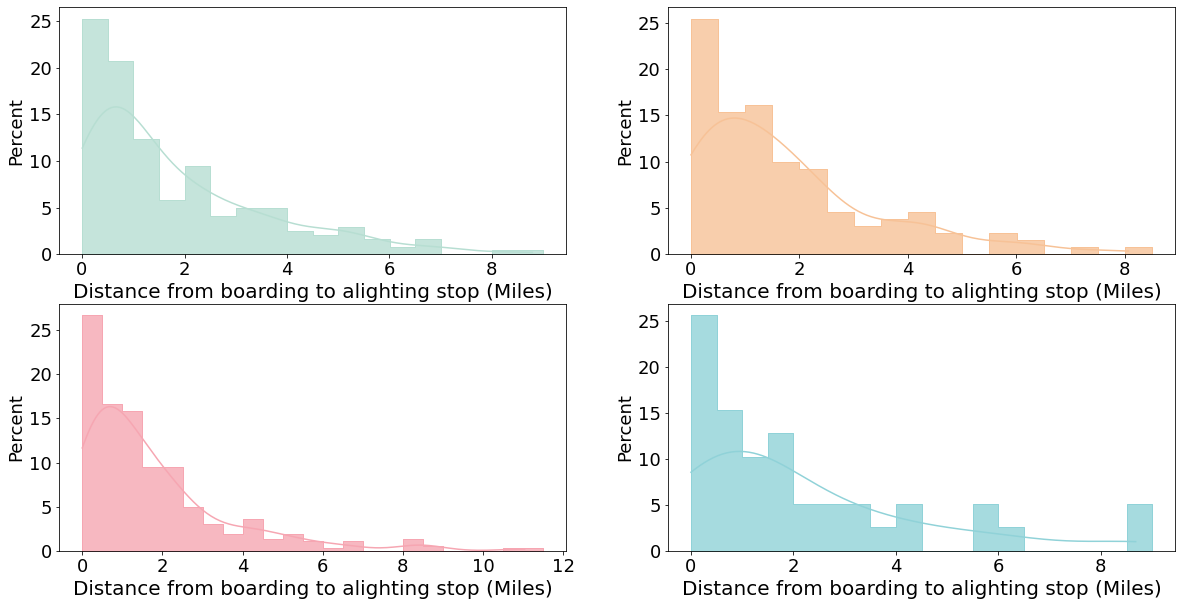

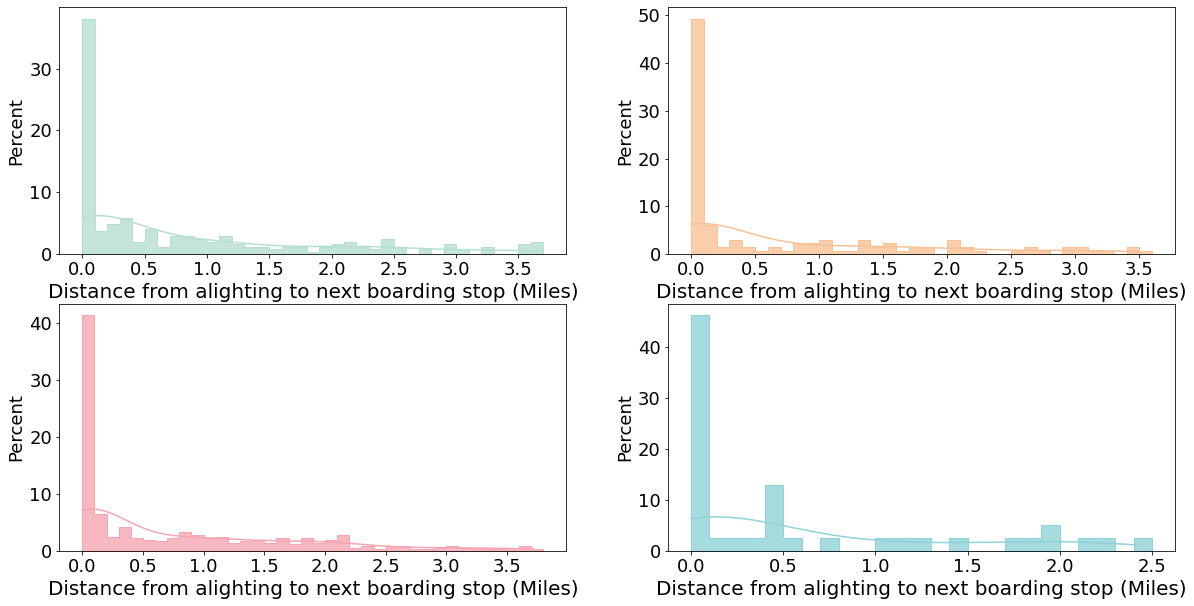

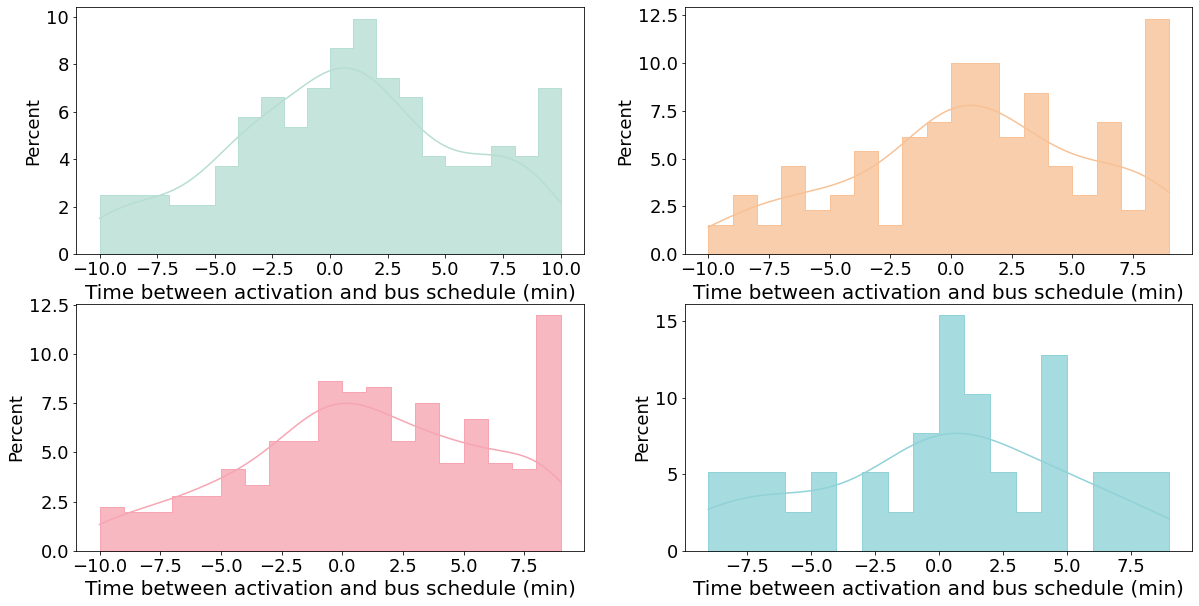

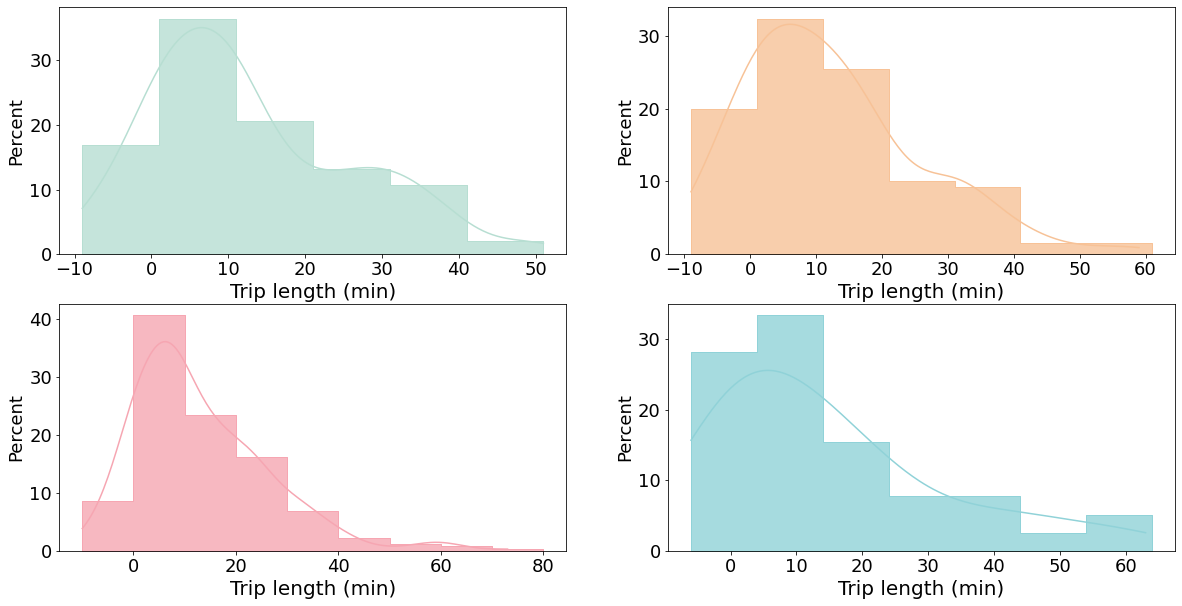

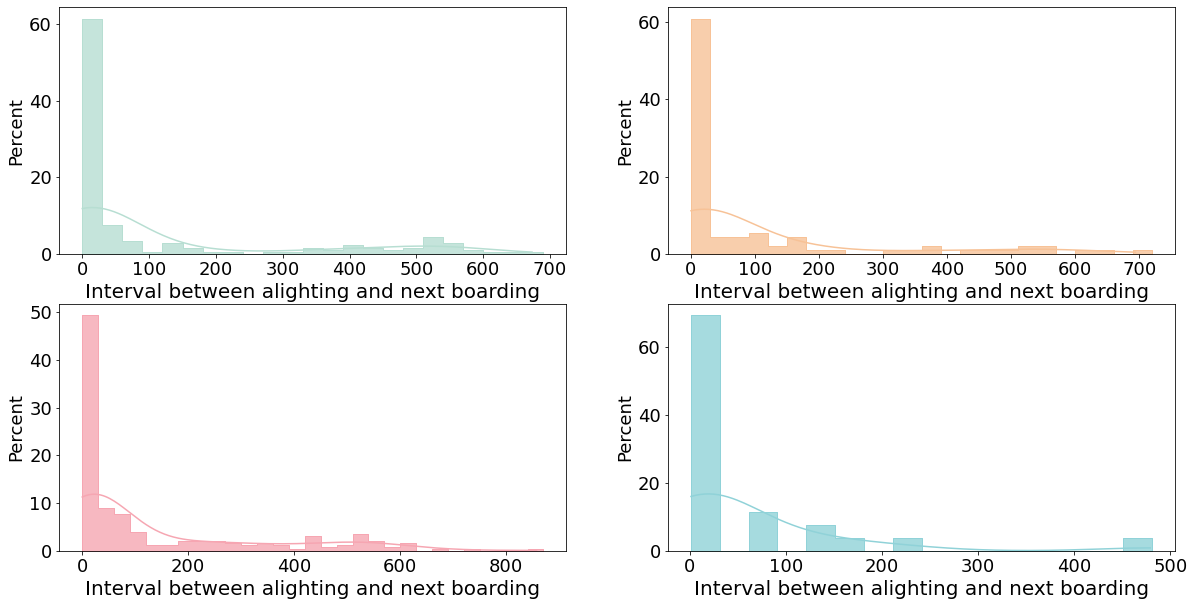

In [46]:

# full_assigned_alightings.to_csv(f"../../data/tidy/Byte-week-march-2021-inferred-boarding-alightings_for_analysis.csv", index=False) # use to analyze the data for a week
# full_assigned_alightings = pd.read_csv(f"../../data/tidy/Byte-week-march-2021-inferred-boarding-alightings_for_analysis.csv")

SNS_palette = ['#f0e594','#57b884','#ffab8d','#ff6a9e'] # SNS color palette
carnival_vintage = ['#b7ded2','#f6a6b2','#f7c297','#90d2d8'] # carnival vintage Color Palette

def plot(column,data,x_label,color,binwidth,setlimit = True,xlimit =None ,ylimit = None, sharey=False,sharex = False):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharey=sharey,sharex = sharex)

    j,x = 0,0

    for i in range(4):
        num = i+1
        print(f'********************\n FOR TYPOLOGY {num}')
        typology = data[data.Typology == num]

        print(f'mean {typology[column].mean()}')
        print(f'95th percentile: {np.percentile(typology[column], 95)}')
        print(f'median {typology[column].median()}')
        print(f'mode {typology[column].mode()}')
        if i == 1:
            x = 1
            j = 0
        if i == 2:
            x = 0
            j = 1
        if i == 3:
            x = 1
            j = 1

        g = sns.histplot(data = typology
                ,x = column
                # ,color = 'navy'
                ,alpha = 0.8
                ,stat='percent'
                # ,bins = 50
                 ,binwidth = binwidth
                 ,kde = True
                     ,element = 'step'
                 # ,hue = 'Typology'
                 # , palette= 'tab10'
                 , color=color[i],
                 ax=ax[x][j]
                )

        if setlimit == True:
            g.set_xlim(0, xlimit)
            g.set_ylim(0, ylimit)

        g.set_xlabel(x_label, fontsize = 20)
        # g.set_title(title= , fontsize = 20)

    return g

print('\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\n'
      'Distance from boarding to alighting stop (Miles)')
g = plot('dist_boarding_alighting',full_assigned_alightings,x_label = 'Distance from boarding to alighting stop (Miles)',color = carnival_vintage,binwidth = 0.5,setlimit = False,xlimit =0.5 ,ylimit = None)

print('\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\n'
      'Distance from alighting to next boarding stop (Miles)')
g = plot('dist_alighting_next_boarding',full_assigned_alightings,x_label = 'Distance from alighting to next boarding stop (Miles)',color = carnival_vintage,binwidth = 0.1,setlimit = False,xlimit =0.5 ,ylimit = None)

print('\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\n'
      'Time between activation and bus schedule (min)')
g = plot('diff_activation_boarding',full_assigned_alightings,x_label = 'Time between activation and bus schedule (min)',color = carnival_vintage,binwidth = 1,setlimit = False,xlimit =0.5 ,ylimit = None) # find the p95 for the negative time difference

print('\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\n'
      'Trip length (min)')
g = plot('diff_trip_length',full_assigned_alightings,x_label = 'Trip length (min)',color = carnival_vintage,binwidth = 10,setlimit = False,xlimit =0.5 ,ylimit = None)

print('\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\n'
      'Interval between alighting and next boarding')
g = plot('diff_alighting_next_boarding',full_assigned_alightings,x_label = 'Interval between alighting and next boarding',color = carnival_vintage,binwidth = 30,setlimit = False,xlimit =0.5 ,ylimit = None)

In [47]:
ddddssdfasf

NameError: name 'ddddssdfasf' is not defined

-----------------------------------------------------
-------------------------------------------------------
----------------------------------------------
# End of document

In [ ]:

#########################################################################################################

#############################################################################
### Extract percentage of inferred boardings from those who have multiple activations in a day

In [ ]:
bytemark_with_route_ids_path_boardings_routes_only = r"../../data/tidy/Byte-March-inferred-boarding-greedy-algorithm-with-GTFS.csv"
bytemark_with_route_ids_path_boardings_routes_only_inferred_uninferred = r"../../data/tidy/Byte-April-inferred-uninferred-boarding.csv"
def get_data(Path):
    print('Acquiring the data')
    # LOAD BOARDING DATA
    Boardings_data = pd.read_csv(Path, index_col='Unnamed: 0', low_memory=False)
    Boardings_data.Date = pd.to_datetime(Boardings_data.Date)
    Boardings_data.Time_Scanned = pd.to_datetime(Boardings_data.Time_Scanned)
    print('dataframe contains', len(Boardings_data),'rows')
    return Boardings_data
Boardings_data = get_data(bytemark_with_route_ids_path_boardings_routes_only)
Boardings_data

### Temp
##### Load in 11.6 to do spatial clustering on a Janury week with inferred stops in 2022

In [ ]:
# extract percentage of inferred boardings from those who have multiple activations in a day

def drop_one_time_activations():
    temp_b_files = pd.DataFrame()
    for date in bytemark_sample_used.Date.unique():
        temp = bytemark_sample_used[bytemark_sample_used.Date == date]
        temp = temp[temp.groupby('UUID').UUID.transform(len) > 1]
        temp_b_files = temp_b_files.append(temp)
    return temp_b_files
Boardings_data_no_one_activation = drop_one_time_activations()
Boardings_data_no_one_activation
Boardings_data_no_one_activation.to_csv(r"../../data/tidy/Byte-April-Boardings_data_no_one_activation.csv", # this is for obtaining the matching rate after removing all one time data
                                  index=True,)
##
#########################################################################################################

Run this data once to get the percentage (next week)
#############################################################################

# for april
Matching rate for boarding = 81.6% using 100 meters and 10 minutes
93% using 200 meters and 15 minutes

In [ ]:
# import plotly.express as px
# df = px.data.gapminder().query("year==2007")
# fig = px.scatter_geo(df, locations="iso_alpha", color="continent",
#                      hover_name="country", size="pop",
#                      projection="natural earth")
# fig.show()

In [ ]:
# df = px.data.gapminder()
# fig = px.scatter_geo(df, locations="iso_alpha", color="continent",
#                      hover_name="country", size="pop",
#                      animation_frame="year",
#                      projection="natural earth",
#
#                      width=1200,height=700)
# fig.show()

In [ ]:
# fig = px.scatter(bytemark_sample_used, x="Longitude", y="Latitude", color="Price",width=1000,height=1000,animation_frame = 'Faretype')
# fig.show()

In [ ]:
# bytemark_sample_used
# # get the uninferred
# temp = BytemarkWithClosestStopAndRoutes_[BytemarkWithClosestStopAndRoutes_.StopID.isna()]
# temp = temp[['Date','UUID','Serial','Faretype','Time_Scanned','Latitude', 'Longitude','Program']]
# temp

In [ ]:
# temp.to_csv(r"../../data/tidy/Byte-March-May-infeasible-activations.csv",index=True)
# temp

# Boarding stops and their possible route IDs

In [ ]:
# BytemarkWithClosestStopAndRoutes_ = load_data(r"../../data/tidy/Byte-March-inferred-boarding-greedy-algorithm-with-GTFS.csv")
# BytemarkWithClosestStopAndRoutes_

## 82% of the original file was inferred for 100 m and 10 minutes

## Clean the data from duplicate activations within 10 minutes in the same stop (NO NEED ANYMORE?)

# Boarding stops and their possible trip IDs (cleaned)

In [ ]:
# def Clean_data(bytemark_sample):
#
#     # 1000+ iterations, and for some reason we get a Setting With Copy Warning for each one of the iterations (makes the process too slow. Also, don't want to see 1000+ warnings on every run):
#     ## So, turn off the warning for now with:
#     pd.set_option('mode.chained_assignment', None)
#     ##
#
#     # set time buffer
#     buffer = 10
#
#     # create an empty data frame to append the time differences to it
#     df_uuid = pd.DataFrame(columns = ['time_diff'])
#     df_uuid_stopid = pd.DataFrame(columns = ['time_diff'])
#     # create an empty list to append the indices that will be removed later from the main data frame
#     i = 0
#     indices_to_remove=[]
#     # return indices_to_remove
#     for uuid in bytemark_sample.UUID.unique():
#         temp = bytemark_sample[(bytemark_sample['UUID'] == uuid)]
#         # calculate the time differences that people wait between their activations and append it
#         temp['time_diff_uuid'] = temp.Time_Scanned.diff() # used Time_Scanned_TrueDate here because of the above code (not using the date in to infer boarding. fix later
#         df_uuid = df_uuid.append(temp, ignore_index = True) #
#         # return df_uuid
#         # print('UUID:',uuid)
#
#         for stopid in temp.StopID.unique(): # using StopID instead of the unique ID because the whole issue with GTFS not containing the unique ones
#             temp2 = temp[(temp['StopID'] == stopid)]
#             temp2['time_diff_uuid_stopid'] = temp2.Time_Scanned.diff() # used Time_Scanned_TrueDate here because of the above code (not using the date in to infer boarding. fix later
#             df_uuid_stopid = df_uuid_stopid.append(temp2, ignore_index = True) #
#
#             ## get indices of activations from the same uuid and the same stop that are less than n minutes apart
#             indices = temp2.index[temp2['time_diff_uuid_stopid'] < pd.Timedelta(buffer, unit='m')].tolist()   ## Returns a list of indices of values that satisfy the comparison. you should compare either by converting your threshold using "pd.Timedelta" as shown, or by converting the column you want to compare to the units you need using "df['date_diff'].dt.days"
#             # display(indices) # displays the list created for every uuid
#
#             indices_to_remove.extend(indices)
#
#             # print('stopid:',stopid)
#             i = i + 1
#             if i ==500:
#                 return indices_to_remove
#
#     print('Activations from the same user and stop less than',buffer,'minutes apart = ', len(indices_to_remove), 'activations')
#     # Display(indices_to_remove)
#     bytemark_sample_clean = bytemark_sample.drop(indices_to_remove)
#     # bytemark_sample_clean
#     return bytemark_sample_clean, df_uuid , df_uuid_stopid

## Normal outputs when not testing
# BytemarkWithClosestStopAndRoutes_clean, df_uuid, df_uuid_stopid = Clean_data(BytemarkWithClosestStopAndRoutes_)
#
# print('the cleaning removed', (1 - (len(BytemarkWithClosestStopAndRoutes_clean)/len(BytemarkWithClosestStopAndRoutes_))) * 100,"% of the inferred boarding locations")
#
# bytemark_with_route_ids = BytemarkWithClosestStopAndRoutes_clean.copy(deep = True)
# bytemark_with_route_ids
#

## for testing the cleaning issues:
# BytemarkWithClosestStopAndRoutes_clean= Cle-

In [ ]:
# bytemark_with_route_ids.to_csv(r"../../data/tidy/Byte-March-inferred-boarding-greedy-algorithm-with-GTFS_cleaned.csv",
#                                   index=True,)

In [ ]:
# bytemark_with_route_ids



# Cleaned

In [ ]:
# bytemark_with_route_ids

### 0% of preliminary boarding inference points were removed for being duplicates FOR SOME UNKNOWN REASON

## Plot the distribution of peoples activation intervals in the same stops to determine the appropriate threshold for the above function

In [ ]:
# df_uuid = df_uuid['time_diff_uuid']
# df_uuid_stopid = df_uuid_stopid['time_diff_uuid_stopid']

#### The distribution of the amount of time people wait between activations in the same station (minutes)
### After using the dates and timestamps to obtain boarding stops. The frequency of same user same stop usage dropped significantly for some reason. This makes it seem as though no cleaning (the above step) is necessary but this can't be. Investigate further.

In [ ]:
# display(df_uuid_stopid)
# df_uuid_stopid.index[df_uuid_stopid['time_diff_uuid_stopid'] < pd.Timedelta(60, unit='m')].tolist()
#

In [ ]:
# # investigate the frequency here
# # the distribution of the amount of time people wait petween activations in the same station
# (df_uuid_stopid['time_diff_uuid_stopid'] / np.timedelta64(1, 'm')).hist(bins=range(0,120,5)) # convert the time deltas to time units (m,h,s,M, etc.) and plot it in a range from x to y in intervals of z.
# plt.xlabel('Time between activations (min)')
# plt.ylabel('# of activations');
#

#### The distribution of the amount of time people wait petween activations in the same station (hours)

In [ ]:
# (df_uuid_stopid['time_diff_uuid_stopid'] / np.timedelta64(1, 'h')).hist(bins=range(1,100,1)) # convert the time deltas to time units (m,h,s,M, etc.) and plot it in a range from x to y in intervals of z.
# plt.xlabel('Time between activations (hour)')
# plt.ylabel('# of activations');
#

### From the plots, the suitable threshold for duplicate activations = 10 minutes (which was then used in the above function)

##### Next function assigns all possible route IDs to the activation. Each in a separate column labeled (route_id_No_0, route_id_No_1, route_id_No_2, etc.) (OLD)
##### Boarding stops and their possible route IDs (old) (not necessary anymore since routes are now assigned from the beginning)

In [ ]:
# # # fixed to include all possible route IDs (up to 50 in the first example)
# # # Stop IDs have multiple trips with multiple routes. make sure to get all possible routes of every stop ID. (fixed)
# # def assign_route_ids(bytemark):
# #     df = bytemark.copy(deep=True)
# #
# #     for index, row in df.iterrows():
# #
# #         # set empty data frame to populate with possible trips and routes for this user
# #         temp = pd.DataFrame()
# #
# #         ## check all trip_id columns in this row (they start from 11th column index here, dont change that)
# #         ### append them together
# #         for i in range (bytemark_with_trip_ids.columns.get_loc("trip_id_No_0"),len(bytemark_with_trip_ids.columns)):
# #             # print(bytemark_with_trip_ids.iloc[:,i].name)
# #             ## check each column trip id value and get the corresponding row that contains that trip ID from the 'trips' file
# #             ### append that row to the empty temp dataframe. Repeat untill all columns are checked and we have a table of all possible trips and route IDs
# #             temp = temp.append(trips.loc[trips['trip_id'] == row[bytemark_with_trip_ids.iloc[:,i].name]])
# #
# #
# #         # the output is two or more rows since we don't use full time and date.
# #         # assign all of the route IDs to different columns to assign all possibilities
# #         if temp.empty:
# #             continue
# #         else:
# #             #make multiple route ids here
# #             # go through each item in temp and assign it to a new column in the main dataset. all possibilities will be included.
# #             temp = temp.reset_index()
# #             for index_, row_ in temp.iterrows():
# #                 suffix = '_No_' + str(index_)
# #                 col_name="route_id"+suffix
# #                 df.loc[index,col_name] = temp['route_id'][index_]
# #
# #     # print('Matched trips:',((len(df)-df.route_id.isna().sum())/ len(df))*100,'%')
# #     return df
# # bytemark_with_trip_route_ids = assign_route_ids(bytemark_with_trip_ids)
# # bytemark_with_trip_route_ids
#

## Boarding inference is finished. 62% of the original data now have boarding stops assigned to them

# Alighting inference

###### flow:

###### for every activation:

######    Take the stop id inferred for boardings
######    subset the route stop undummied to obtain a list of stops in the same route
######    check the distance between them and the next boarding location
######    assign within threshold

###### for loop used to loop thorugh the required columns (use len(df before assigningthe possible trip IDs) instead of 11 for a more robust function)
###### for i in range (11,len(bytemark_with_trip_ids.columns)):
######    # print(bytemark_with_trip_ids.iloc[:,i].name)
######    ## check each column trip id value and get the corresponding row that contains the route id from the 'trips' file
######    ### append that row to the empty temp dataframe. Repeat untill all columns are checked and we have a table of all possible trips and route IDs
######    temp = temp.append(trips.loc[trips['trip_id'] == row[bytemark_with_trip_ids.iloc[:,i].name]])
###### display(temp)


# Boarding stop, alighting stop, and their route
#### use the route table again to create a route with stop table

In [ ]:
# stop_routes = route_timetable_.copy(deep = True)
# stop_routes = stop_routes[['route_id','StopID']]
# stop_routes = stop_routes.drop_duplicates(keep='first')
# tempstops = full_stops.copy(deep = True)
# tempstops = tempstops[['StopID','Latitude','Longitude','StopReportLabel','UniqueStopInternalID','StopReportLabel']]
# stop_routes = stop_routes.merge(tempstops, on = 'StopID',how='inner')
# stop_routes

In [ ]:
# bytemark_with_route_ids = load_data(r"../../data/tidy/Byte-March-inferred-boarding-greedy-algorithm-with-GTFS_cleaned.csv")

In [ ]:
# def infer_alightings(Bytemark_,stops):
#     stops = stops.drop_duplicates(subset=['StopID'],keep='first') # remove this line later and account for all possible routes
#     # 1000+ iterations, and for some reason we get a Setting With Copy Warning for each one of the iterations (makes the process too slow. Also, don't want to see 1000+ warnings on every run):\n",
#     ## So, turn off the warning for now with:\n",
#     pd.set_option('mode.chained_assignment', None)
#
#     def closest_point(point, points):
#
#         # print(points)
#         if points:
#             # Find closest point from a list of points.
#             # filter to not take anything more that a certain euclidean distance (0.001 roughly equals 100 meters)
#             euclidean = cdist([point], points)
#
#
#             euclidean_s = euclidean[np.where((euclidean > 0) & (euclidean < 0.02))] #2000 m?
#             if euclidean_s.size:
#                 #slight caveat. if you dont use euclidean_s as it is used above, it takes the index from the shortened list and compares it the the full list of the full_stops (fixed by using euclidean_s as a separate stipulation for making the inference)
#
#
#                 #### we dont need the next code because the point being compared is the next boarding stop which might be the alighting stop no problem
#                 # # we need the second smallest value because the point being compared is one of the stops. It will always return the same stop as the closest point as the distance is always zero",
#                 # euclidean = euclidean[0]
#                 # IndexOfSecondSmallestVlues = euclidean.argsort()[:2] # argsort return the indices of the smallest or biggest values",
#                 # ind = IndexOfSecondSmallestVlues[1] # is the second smallest index",
#
#                 # if points[euclidean.argmin()] == point: # this if statement is because some times the stop we are comparing is part of the stops we compare it with, which results in the same stop being inferred due to distance being 0 so we assign the second stop in line. And sometimes it's not part of them so we need to assign the stop with the minimum distance instead.
#                 #     return points[ind],ind # uses index of minimum distance >0 in the list between a 'point' and 'points' to get the lon lat from 'points' list
#                 # else:
#                 #     return points[euclidean.argmin()], euclidean.argmin()
#                 ####
#
#                 ## return two elements: the stop location, and the index of the stop location to get other stop information from the beginning (you have to reset the index of the dataframe from which these stops came from)
#                 ### doing this will abolish the need for the (match_value) function completely (try to apply this everywhere.
#                 return points[euclidean.argmin()], euclidean.argmin() # old
#             else:
#                 # return 2 items because i'm assigning two items in the code below
#                 return 9999999,9999999 # 9999999 in the assigned stop location column means it does not meat the distance threshold requirement
#         else:
#             return 9999999
#     def match_value(df, col1, x, col2):
#         # Match value x from df1 row to value in df2.
#         return df[df[col1] == x][col2].values[0] # finds the values of closest stop in the full_stops data and then assigns the value of the column you want (index 0 means the first value) of the resulting data frame
#
#     Bytemark = Bytemark_.copy(deep=True)
#     number = len(Bytemark)
#
#     stops['StopLocation'] = [(x, y) for x,y in zip(stops['Latitude'], stops['Longitude'])]
#
#     # Create new column for inference
#     Bytemark['Alighting_StopID'] = np.nan
#     Bytemark['AssignedAlightingStopLonLat'] = np.nan
#     Bytemark['Alighting_route_id'] = np.nan
#     Bytemark['Alighting_UniqueStopInternalID'] = np.nan
#
#     # Pandas wont set a tuple over any other value and returns an error. It does, however, set tuples over other tuples. That's why I made the new column a list of tuples.
#     Bytemark.AssignedAlightingStopLonLat = [(9999999,9999999)] * len(Bytemark)
#
#     for date in Bytemark.Date.unique():
#         print(date)
#         temp_ = Bytemark[(Bytemark['Date'] == date)] # subset by days
#
#         for uuid in temp_.UUID.unique(): # Subset by activation
#
#             temp = temp_[(temp_['UUID'] == uuid)]
#
#             if len(temp)> 1: # Check if more than one activation in a day
#                 # PassengerFullTripID += 1
#
#                 ## if two consecutive stops are the same, remove the first one (validate this later (maybe its not a good choice))
#                 temp = temp.loc[temp.StopID.shift(-1) != temp.StopID] # this solves the issue of boarding from a stop to the same stop being inferred in case the there are not only two trips in the day which are inferred to the same stop
#                 # So the above uses boolean critieria, we compare the dataframe against the dataframe shifted by -1 rows to create the mask
#                 # This returns the second consective value and deletes the first it encounters
#                 # Using shift(1) will return the first instead.
#
#                 ### (Untested) Here is an update that will make it work with multiple columns if needed. Use ".any(axis=1)" to combine the results from each column:
#                 # cols = ["col1","col2","col3"]
#                 # de_dup = a[cols].loc[(a[cols].shift(1) != a[cols]).any(axis=1)]
#
#
#                 ## create a column of next boarding stops. shift all the values upwards. and then assign the last next boarding as the first boarding because each value in this column will be compared with the locations of stops on the same route later. so this one will be considered the last destination
#                 ## StopID here is the boarding stop
#                 temp["NextBoardingStop"]= temp["StopID"].shift(-1)
#                 temp['NextBoardingStop'].iloc[-1] = np.array(temp.StopID.head(1))[0]
#
#
#                 if len(temp) < 2:
#                     temp.NextBoardingStop = np.nan
#                     # display(temp)
#                     continue
#
#                 # display(temp.StopID.iloc[0])
#
#                 if temp.NextBoardingStop.iloc[-1] == temp.StopID.iloc[-1]:
#                     # display(temp)
#                     temp.drop(temp.tail(1).index,inplace=True) # drop last row in case last activation is the same as the first (assumption: the last destination is actually the first one. But accidental activation has been done)
#                     # display(temp)
#
#
#                 # temp = temp.loc[temp.NextBoardingStop.shift(-1) != temp.NextBoardingStop]
#
#                 if len(temp) < 2:
#                     # display(temp)
#                     continue
#
#
#
#
#                 # add stop location of each next stop location for greedy inference later
#                 tempstops__ = stops.copy(deep = True)
#                 tempstops__ = tempstops__ [['StopID','StopLocation']]
#                 tempstops__.columns = ['NextBoardingStop','StopLocation']
#
#                 temp.NextBoardingStop = temp.NextBoardingStop.astype('int')
#                 temp.NextBoardingStop = temp.NextBoardingStop.astype('str')
#                 temp = temp.reset_index()
#                 temp = temp.merge(tempstops__, on = 'NextBoardingStop') # cant add to all because some stop IDs are not in the dummies folder (Am). its working now because it was temporarily fixed by removing these stops from the inference above. (fix later) (old?)
#                 temp = temp.set_index('index')
#                 temp.index.name = None
#
#                 for index, row in temp.iterrows(): # Select next activation
#                     ## do we need a custom passenger trip ID and full trip ID?
#
#                     # Take the route id inferred for this trip and subset the route stop undummied to obtain a list of stops in the same route
#                     ## what should happen: obtain a list of all possible routes and subset by them (possibly by changing the above assign routes function to give routes for each stop seperately and avoid the multiplication of routes.)\
#                     ### then see which stop in which of these routes is closer to the next boarding
#                     stops_ = pd.DataFrame()
#                     for i in range (7,len(Bytemark_.columns)):
#                         # return Bytemark_.iloc[:,i].name ###
#                         ## check each column trip id value and get the corresponding row that contains the route id from the 'trips' file
#                         ### append that row to the empty temp dataframe. Repeat untill all columns are checked and we have a table of all possible trips and route IDs
#                         stops_ = stops_.append(stops.loc[stops['route_id'] == row[Bytemark_.iloc[:,i].name]])
#
#
#                     if stops_.empty: # an empty stops file will try to be used below. Check the file to avoid an error when that happens.
#                         continue
#                     else:
#                         # set the station closest to the next stop in this route
#                         stops_ = stops_.reset_index()
#                         stoplocation, index__ = closest_point(row['StopLocation'], list(stops_['StopLocation']))
#
#                         if index__ != 9999999: # if there was no inference, The value of the cell stays the same (a tuple of nines)
#                             Bytemark['AssignedAlightingStopLonLat'][index] = stoplocation
#                             Bytemark['Alighting_route_id'][index] = stops_.route_id[index__]
#                             Bytemark['Alighting_StopID'][index] = stops_.StopID[index__]
#                             Bytemark['Alighting_UniqueStopInternalID'][index] = stops_.UniqueStopInternalID[index__]
#                         else:
#                             continue
#
#                     # return Bytemark
#
#             else:
#                 continue
#     # choose the columns to keep and rename them to something more readable
#     Bytemark = Bytemark[['UUID','Date','Faretype','Time_Scanned','StopID','AssignedAlightingStopLonLat','Alighting_StopID','Alighting_route_id','Alighting_UniqueStopInternalID']] # fix later
#     Bytemark.columns = ['UUID','Date','Faretype','Time_Scanned','BoardingStopID','Alighting_StopLonLat','Alighting_StopID','Trip_route_id','Alighting_UniqueStopInternalID']
#
#
#     return Bytemark
#
# BytemarkAlightings = infer_alightings(bytemark_with_route_ids,stop_routes) #Should this be full stops?

# Clean from the uninferred activations
# BytemarkAlightings_ = BytemarkAlightings[BytemarkAlightings.Alighting_StopLonLat!=(9999999, 9999999)]
# BytemarkAlightings_.to_csv(r"../../data/tidy/Byte-March-May-inferred-boarding-alighting-greedy-algorithm-with-GTFS.csv",
#                                   index=False,)
# BytemarkAlightings_

In [ ]:
# print('accuracy of alighting inference of the boarding inferred =',(len(BytemarkAlightings_)/len(bytemark_with_route_ids))*100,'%')

## The numbers in the seed matrix DIAGONAL are produced by at least three reasons:
### 1: when the first and last activations of the day are at the same station. The last line will have the same stop at both boarding and alighting (solved)
### 2: a special case of the first case: when the only two times the user activates its around the same station. The duplicates are removed and one is left. which is considered the first and last activation of the day. which is a loophole in the code that assigns the first station as the last destination. Resulting in a trip to the same stop (fixed)
### 3: ?


###### The way the above algorithm works is by taking the possible routes of the boarding location and then checking all the stops in those routes. Then it compares all of them to the next boarding stop. So, if the next stop is in one of the boarding routes. it is going to be inferred as the alighting of the first trip no matter what the actual alighting stop was. This can't be fixed with the current data.

###### The problem I wrongly aimed to solve by trying to fix the above statement (which I undid) is that some stops are inferred as the boarding and alighting at the same time ( tried to fix by the cleaning function and removing rows where the first boarding and next boarding are the same in the alighting function) (look at this again)

###### Maybe the next boarding stop field is sometimes populated with the previous boarding stop in line 653 (the shift). Tried to fixusing the above methods. Not always successful (some still got through and the matching rate dropped waaay down.

# Matching rate

In [ ]:
# number_of_full_used_data_points = len(bytemark_sample_used)
# original_number_of_inferred_boardings = len(BytemarkWithClosestStopAndRoutes_)
# number_of_cleaned_inferred_boardings = len(bytemark_with_route_ids)
# number_of_inferred_alightings = len(BytemarkAlightings_)
# display(number_of_full_used_data_points)
# display(original_number_of_inferred_boardings)
# display(number_of_cleaned_inferred_boardings)
# display(number_of_inferred_alightings)
#

In [ ]:
# print('Boarding matching rate (cleaned from false activations) from the full original data:',100*number_of_cleaned_inferred_boardings/number_of_full_used_data_points,'%\n')
#
# print('Alighting matching rate from the cleaned boarding inferred data:',100*number_of_inferred_alightings/number_of_cleaned_inferred_boardings,'%')
#

# Appendix


## Replace below code with the one above once its ready

In [ ]:
# def assign_points_to_closest_stop_with_gtfs(full_stops,bytemark):
#     full_stops = full_stops.drop_duplicates(subset=['StopID'],keep='first') # REMOVE DUPLICATE STOPS. WE ONLY NEED THEM ONCE
#     df1 = full_stops.copy(deep=True)
#     df2 = bytemark.copy(deep=True)
#
#     # set a time buffer
#     buffer = 10
#
#     # use double return as in the alighting function to infer the location and the stop ID and maybe more all at once. yOU WONT NEED THE NEXT (match_value) FUNCTION.
#     def closest_point(point, points):
#         if points:
#             # Find closest point from a list of points.
#             # filter to not take anything more that a certain euclidean distance (0.001 roughly equals 100 meters)
#             euclidean = cdist([point], points)
#
#             euclidean_s = euclidean[np.where(euclidean < 0.001)]
#             if euclidean_s.size:
#             # if True:
#                 #slight caveat. if you dont use euclidean_s as it is used above, it takes the index from the shortened list and compares it the the full list of the full_stops (fixed by using euclidean_s as a separate stipulation for making the inference)
#
#                 return points[euclidean.argmin()] # uses index of minimum distance in the list between a 'point' and 'points' to get the lon lat from 'points' list
#             else:
#                 return 9999999 # 9999999 in the assigned stop location column means it does not meat the distance threshold requirement
#         else:
#             return 9999999
#     # def match_value(df, col1, x, col2):
#     #     # Match value x from df1 row to value in df2.
#     #     return df[df[col1] == x][col2].values[0] # finds the values of closest stop in the full_stops data and then assigns the value of the column you want (index 0 means the first value) of the resulting data frame
#
#     df1['StopLocation'] = [(x, y) for x,y in zip(df1['Latitude'], df1['Longitude'])]
#     df2['ActivationLocation'] = [(x, y) for x,y in zip(df2['Latitude'], df2['Longitude'])]
#
#     # Create new column for inference
#     df2['AssignedStopLonLat'] = np.nan
#     # Pandas wont set a tuple over any other value and returns an error. It does, however, set tuples over other tuples. That's why I made the new column a list of tuples (9999999,9999999).
#     df2.AssignedStopLonLat = [(9999999,9999999)] * len(df2)
#
#     for index, row in df2.iterrows():
#
#         # get the lower and upper thresholds for each activation
#         mini = df2.loc[index,'Time_Scanned'] - pd.Timedelta(minutes = buffer) ## this results in a time stamps
#         maxi = df2.loc[index,'Time_Scanned'] + pd.Timedelta(minutes = buffer) ## time stamps
#         timestamp = pd.to_datetime([mini])
#         mini = timestamp.time.astype('str')[0]
#         timestamp = pd.to_datetime([maxi])
#         maxi = timestamp.time.astype('str')[0]
#
#         ## filter stop_times file to get only the stops used around the activation time
#         temp = stop_times.copy(deep = True)
#         temp = temp.between_time(mini,maxi)
#         temp = list(temp['stop_id'])
#
#
#
#         # take those stop names and filter the full stops file to get those stops lon/lat
#         temp = df1[df1['StopID'].isin(temp)] # (some stops won't show if you're using the undummied file instead of the full stops file)
#
#         # check the proximity of the activation to this list of stops
#         # and assign to the stop within threshold
#         df2['AssignedStopLonLat'][index] = closest_point(row['ActivationLocation'], list(temp['StopLocation']))
#
#     df1 = df1.append(pd.Series(), ignore_index=True) # add a row of nans at the end to solve the case of empty list
#     df1['StopLocation'].iloc[-1] = 9999999 # Assign last row value to 9999999 so it is inferred instead of a real stop if the closest is more that the threshold
#
#     # { just to split the functions (see next function that does what was done in here)
#     df2['StopID'] = [(9999999,9999999)] * len(df2)
#     df2['UniqueStopInternalID'] = [(9999999,9999999)] * len(df2)
#     ## }
#
#     # turn all 9999999 values to NaN
#     df2["AssignedStopLonLat"].replace({9999999: np.nan}, inplace=True)
#
#     return df2 #df2_clean # df2_clean
#
# BytemarkWithClosestStop_ = assign_points_to_closest_stop_with_gtfs(full_stops,bytemark_sample_used)
# # print('centroids with their closest full_stops:')
# display(BytemarkWithClosestStop_)

### Replaced the next code with the one above (just see if anything needs to be used up there)

(old)try to get stop IDs and fix the index out of bounds issue here (there was an issue that I thought splitting the above function to two would help solve it faster. The above function was too slow to perform the first part that I found it easier to first get the outcome of it, then fix the issue with the second (next) function)

(Old) inference decreased from 75 to ?? because of the undummied stops (search 'Am') (the full stops file that has only the stops found in the GTFS had 75%, which means the issue is with Am's route file). Ask for updated copy.

In [ ]:
# start temp code

In [ ]:
# full_stops

In [ ]:
# # test intersection of dataframes here:
# d = {'stop id': [15, 20,30,40,60], 'info': ['moh','x','y', 'am','med']}
#
# f = {'stop id': [15, 20,20,40,60,40,20], 'trip id': [1, 2,3,4,5,6,7]}
#
# stops = pd.DataFrame(data=d)
# routes = pd.DataFrame(data=f)
# display(stops)
# display(routes)

In [ ]:
# # normal merge
# stops = pd.merge(stops, routes, how ='inner', on = 'stop id')
#
# stops['stop id'] = stops['stop id'].astype('str')
# stops['trip id'] = stops['trip id'].astype('str')
# stops

In [ ]:
# # aggregate
# df = stops.groupby('stop id').agg({'info':'first',
#                              'trip id': ', '.join,
#                              }).reset_index()
# df

In [ ]:
# new = df["trip id"].str.split(", ", n = 0, expand = True)
# new

In [ ]:
# # df.drop(columns =["trip id"], inplace = True)
# index_ = 0
# for column in new:
#
#     suffix = '_No_' + str(index_)
#     col_name="trip_id"+suffix
#     df[col_name] = new[index_]
#     index_ += 1
# df

# end of temp code

In [ ]:
# def assign_boarding_stopID(full_stops, bytemark):
#     full_stops=full_stops.drop_duplicates(subset=['StopID'],keep='first') # remove this line later and account for all possible routes

    # df1 = full_stops.copy(deep=True)
    # df2 = bytemark.copy(deep=True)
    # df2.dropna(subset = ["AssignedStopLonLat"], inplace=True)
    # def match_value(df, col1, x, col2): # THIS IS THE ONLY PLACE LEFT WHERE THE PROBLEM CAN OCCUR (old issue). The assigned stop ID could be different than the one with the lon lat wanted.
    #     # Match value x from df1 row to value in df2.
    #     return df[df[col1] == x][col2].values[0] # finds the values of closest stop in the full_stops data and then assigns the value of the column you want (index 0 means the first value) of the resulting data frame
    #
    # df1['StopLocation'] = [(x, y) for x,y in zip(df1['Latitude'], df1['Longitude'])]
    # df2['ActivationLocation'] = [(x, y) for x,y in zip(df2['Latitude'], df2['Longitude'])]

    # df1 = df1.append(pd.Series(), ignore_index=True) # add a row of nans at the end to solve the case of empty list
    # df1.iloc[-1, df1.columns.get_loc('StopLocation')] = 9999999

    # df2['StopID'] = [match_value(df1, 'StopLocation', j, 'StopID') for j in df2['AssignedStopLonLat']]
    # df2['UniqueStopInternalID'] = [match_value(df1, 'StopLocation', j, 'UniqueStopInternalID') for j in df2['AssignedStopLonLat']]
    #
    # df2['AssignedStopLatitude'], df2['AssignedStopLongitude'] = df2.AssignedStopLonLat.str
    #
    # df2 = df2.drop('ActivationLocation', 1)
    # df2 = df2.drop('AssignedStopLonLat', 1)


    # df2 = df2[['UUID','Faretype','Date','Time_Scanned','Time_Scanned2',"Longitude", "Latitude","AssignedStopLongitude",'AssignedStopLatitude','StopID','UniqueStopInternalID']]
    # df2.columns = ['UUID','Faretype','Date','Time_Scanned','Time_Scanned_TrueDate',"Longitude", "Latitude","AssignedStopLong",'AssignedStopLat','StopID','UniqueStopInternalID'] #rename columns

    # df2_clean = df2[df2['StopID'].notna()]

#     print('Percentage of activations matched to a stop = ',(len(df2_clean)/Number_of_points)*100,'%')
#     print ('Percentage of inferred full_stops from the full full_stops data=', (df2_clean['StopID'].nunique()/len(df1))*100,'%')
#
#     return df2_clean
#
# BytemarkWithClosestStop = assign_boarding_stopID(full_stops, BytemarkWithClosestStop_) # used full_stops instead of route_stop_undummied
# BytemarkWithClosestStop

The cleaning process slashed the activations from 16000 to almost 9000 (old issue).


### Next function assigns all possible trip IDs to the activation. Each in a separate column labeled (trip_id_No_0, trip_id_No_1, trip_id_No_2, ...)

In [ ]:
# trip IDs are now assigned directly from the first boarding code (no need for this next function anymore)
# fixed to include all possible trip IDs (up to 50 in the first example) (old)
# def assign_trip_ids(bytemark):
#
#     Bytemark = bytemark.copy(deep=True)
#
#     for index, row in Bytemark.iterrows():
#
#         mini = Bytemark.loc[index,'Time_Scanned'] - pd.Timedelta(minutes=10) ## time stamps
#         maxi = Bytemark.loc[index,'Time_Scanned'] + pd.Timedelta(minutes=10) ## time stamps
#         ### convert time stamps above to only time to work with 'between_time'
#         timestamp=pd.to_datetime([mini])
#         mini = timestamp.time.astype('str')[0]
#         timestamp=pd.to_datetime([maxi])
#         maxi = timestamp.time.astype('str')[0]
#
#         # temp = stop_times.loc[(stop_times['stop_id'] == row['UniqueStopInternalID']) & (stop_times['departure_time'] == '1900-01-01 06:17:57')]
#         temp = stop_times.loc[stop_times['stop_id'] == row['StopID']]
#
#         # set as index to work with "between_time"
#         # temp.set_index('departure_time',inplace=True)
#         temp = temp.between_time(mini,maxi) #finds the departure times in temp that are between the thresholds
#
#         # the output is two or more rows since we don't use full time and date.
#         # assign all of them to different columns to assign all possibilities
#         if temp.empty:
#             continue
#         else:
#             temp = temp.reset_index()
#             for index_, row_ in temp.iterrows():
#                 suffix = '_No_' + str(index_)
#                 col_name="trip_id"+suffix
#                 Bytemark.loc[index,col_name] = temp['trip_id'][index_]
#
#     # print('Matched trips:',((len(Bytemark)-Bytemark.trip_id.isna().sum())/ len(Bytemark))*100,'%') # no trip id any more
#
#         # display(temp)
#         # if i == 1:
#         #     break
#
#     return Bytemark
#
# bytemark_with_trip_ids = assign_trip_ids(BytemarkWithClosestStop_clean)

In [ ]:
# testing for deletion of duplicate boarding stops in succession

In [ ]:
# d = {'col1': [1, 2,2,3,4,2,4,4,5,6,6,7,6,6], 'col2': ['f', 'f','d','r','u','o','p','o','q','we','rt','yu','646','nj']}
# df = pd.DataFrame(data=d)
# df

In [ ]:
# df = df.loc[df.col1.shift(-1) != df.col1] ## try with shift(1) to see if it returns the first
# df

In [ ]:
# testing to assign the stop with the smallest distance from boarding stop if it is not the same stop. And the second smallest if it is the same stop.

# removed from the code because we are not using the boarding stop, but the next boarding stop, which can very well be the alighting location (especially if the stops opposing each other in the street have the same StopID)

In [ ]:
# euclidean = np.array([100, 19, 4, 14,120])
# euclidean
# i = euclidean.argsort()[:2]
# ind = i[1]
# ind

# if euclidean[euclidean.argmin()] == 3:
#      print (euclidean[ind]) # use return with two outputs (the point and its index) in the function
# else:
#      print(euclidean[euclidean.argmin()])

In [ ]:
# def infer_alightings(Bytemark_,stops):
#     stops = stops.drop_duplicates(subset=['StopID'],keep='first') # remove this line later and account for all possible routes
#     # 1000+ iterations, and for some reason we get a Setting With Copy Warning for each one of the iterations (makes the process too slow. Also, don't want to see 1000+ warnings on every run):\n",
#     ## So, turn off the warning for now with:\n",
#     pd.set_option('mode.chained_assignment', None)
#
#     def closest_point(point, points):
#         global euclidean
#         global temp
#         # print(points)
#         if points:
#             # print('yes')
#             # Find closest point from a list of points.
#             # filter to not take anything more that a certain euclidean distance (0.001 roughly equals 100 meters)
#             euclidean = cdist([point], points)
#
#
#             euclidean_s = euclidean[np.where((euclidean > 0) & (euclidean < 0.02))] #2000 m?
#             if euclidean_s.size:
#                 #slight caveat. if you dont use euclidean_s as it is used above, it takes the index from the shortened list and compares it the the full list of the full_stops (fixed by using euclidean_s as a separate stipulation for making the inference)
#
#
#                 #### we dont need the next code because the point being compared is the next boarding stop which might be the alighting stop no problem
#                 # # we need the second smallest value because the point being compared is one of the stops. It will always return the same stop as the closest point as the distance is always zero",
#                 # euclidean = euclidean[0]
#                 # IndexOfSecondSmallestVlues = euclidean.argsort()[:2] # argsort return the indices of the smallest or biggest values",
#                 # ind = IndexOfSecondSmallestVlues[1] # is the second smallest index",
#
#                 # if points[euclidean.argmin()] == point: # this if statement is because some times the stop we are comparing is part of the stops we compare it with, which results in the same stop being inferred due to distance being 0 so we assign the second stop in line. And sometimes it's not part of them so we need to assign the stop with the minimum distance instead.
#                 #     return points[ind],ind # uses index of minimum distance >0 in the list between a 'point' and 'points' to get the lon lat from 'points' list
#                 # else:
#                 #     return points[euclidean.argmin()], euclidean.argmin()
#                 ####
#
#                 ## return two elements: the stop location, and the index of the stop location to get other stop information from the beginning (you have to reset the index of the dataframe from which these stops came from)
#                 ### doing this will abolish the need for the (match_value) function completely (try to apply this everywhere.
#                 return points[euclidean.argmin()], euclidean.argmin() # old
#             else:
#                 # return 2 items because i'm assigning two items in the code below
#                 return 9999999,9999999 # 9999999 in the assigned stop location column means it does not meat the distance threshold requirement
#         else:
#             return 9999999
#     def match_value(df, col1, x, col2): # THIS IS THE ONLY PLACE LEFT WHERE THE PROBLEM CAN OCCUR. The assigned stop ID could be different than the one with the lon lat wanted.
#         # Match value x from df1 row to value in df2.
#         return df[df[col1] == x][col2].values[0] # finds the values of closest stop in the full_stops data and then assigns the value of the column you want (index 0 means the first value) of the resulting data frame
#
#
#     Bytemark = Bytemark_.copy(deep=True)
#     number = len(Bytemark)
#
#     stops['StopLocation'] = [(x, y) for x,y in zip(stops['Latitude'], stops['Longitude'])]
#     # Bytemark['ActivationLocation'] = [(x, y) for x,y in zip(Bytemark['Latitude'], Bytemark['Longitude'])]
#
#     # bytemark_to_use = bytemark_to_use.set_index(\"Time_Scanned\") #not needed when the data is temp\n",
#
#     # PassengerTripID = 0
#     # PassengerFullTripID = 0
#
#
#     # Bytemark["PassengerTripID"]=np.nan
#     # Bytemark["PassengerFullTripID"]=np.nan
#     # Bytemark = Bytemark[['UUID','Faretype','Date','UniqueStopInternalID','trip_id','route_id','Alighting_StopID','Time_Scanned','Time_Scanned_TrueDate','Latitude','Longitude','StopID']]
#
#     # Create new column for inference
#     Bytemark['Alighting_StopID'] = np.nan
#     Bytemark['AssignedAlightingStopLonLat'] = np.nan
#     Bytemark['Alighting_route_id'] = np.nan
#     Bytemark['Alighting_UniqueStopInternalID'] = np.nan
#
#     # Pandas wont set a tuple over any other value and returns an error. It does, however, set tuples over other tuples. That's why I made the new column a list of tuples.
#     Bytemark.AssignedAlightingStopLonLat = [(9999999,9999999)] * len(Bytemark)
#
#     # return Bytemark
#
#     for date in Bytemark.Date.unique():
#         temp_ = Bytemark[(Bytemark['Date'] == date)] # subset by days
#
#         for uuid in temp_.UUID.unique(): # Subset by activation
#
#             temp = temp_[(temp_['UUID'] == uuid)]
#
#             if len(temp)> 1: # Check if more than one activation in a day
#                 # PassengerFullTripID += 1
#
#                 ## if two consecutive stops are the same, remove the first one (validate this later (maybe its not a good choice))
#                 temp = temp.loc[temp.StopID.shift(-1) != temp.StopID] # see if this solves the issue of boarding from a stop to the same stop being inferred
#                 # So the above uses boolean critieria, we compare the dataframe against the dataframe shifted by -1 rows to create the mask
#                 # This returns the second consective value and deletes the first it encounters
#                 # Using shift(1) will return the first instead.
#
#                 ### (Untested) Here is an update that will make it work with multiple columns. Use ".any(axis=1)" to combine the results from each column:
#                 # cols = ["col1","col2","col3"]
#                 # de_dup = a[cols].loc[(a[cols].shift(1) != a[cols]).any(axis=1)]
#
#
#                 ## create a column of next boarding stops. shift all the values upwards. and then assign the last next boarding as the first boarding because each value in this column will be compared with the locations of stops on the same route later. so this one will be considered the last destination
#                 ## StopID here is the boarding stop
#                 temp["NextBoardingStop"]= temp["StopID"].shift(-1)
#                 temp['NextBoardingStop'].iloc[-1] = np.array(temp.StopID.head(1))[0]
#                 # display(temp)
#                 # display (np.array(temp.NextBoardingStop.tail(1))[0])
#                 # display (np.array(temp.StopID.head(1))[0])
#
#                 # add stop location of each next stop location for greedy inference later
#                 tempstops__ = stops.copy(deep = True)
#                 tempstops__ = tempstops__ [['StopID','StopLocation']]
#                 tempstops__.columns = ['NextBoardingStop','StopLocation']
#                 temp.NextBoardingStop = temp.NextBoardingStop.astype('int')
#                 temp.NextBoardingStop = temp.NextBoardingStop.astype('str')
#                 temp = temp.reset_index()
#                 temp = temp.merge(tempstops__, on = 'NextBoardingStop') # cant add to all because some stop IDs are not in the dummies folder (Am). its working now because it was temporarily fixed by removing these stops from the inference above. (fix later)
#                 temp = temp.set_index('index')
#                 temp.index.name = None
#
#                 # return temp
#
#
#                 for index, row in temp.iterrows(): # Select next activation
#                     # print(index)
#                     ## do we need a custom passenger trip ID and full trip ID?
#                 #     PassengerTripID += 1
#                     # set the trip ID in the temp and the original data by taking the index and the column names and using loc
#                     # temp.PassengerTripID[index] = PassengerTripID  # (not necessary, just for checking)
#                     # Bytemark.loc[temp.index[index],'PassengerTripID'] = PassengerTripID # assign trip ID to each activation (assumes there are no remaining false activations in this cleaned dataset)
#                     #
#                     # temp.PassengerFullTripID[index] = PassengerFullTripID  # (not necessary, just for checking)
#                     # Bytemark.loc[temp.index[index],'PassengerFullTripID'] = PassengerFullTripID  # # assign the same full trip ID to each activation in the day. This considers that the moment you go out and use the bus more
#                     #                                                                 # than once, everything you do during the day is part of a full trip. Fix later.
#
#                     # Take the route id inferred for this trip and subset the route stop undummied to obtain a list of stops in the same route
#                     ## what should happen: obtain a list of all possible routes and subset by them (possibly by changing the above assign routes function to give routes for each stop seperately and avoid the multiplication of routes.)\
#                     ### then see which stop in which of these routes is closer to the next boarding
#                     stops_ = pd.DataFrame()
#                     for i in range (len(bytemark_with_trip_ids.columns),len(bytemark_with_trip_route_ids.columns)):
#                         # print(bytemark_with_trip_route_ids.iloc[:,i].name)
#                         ## check each column trip id value and get the corresponding row that contains the route id from the 'trips' file
#                         ### append that row to the empty temp dataframe. Repeat untill all columns are checked and we have a table of all possible trips and route IDs
#                         stops_ = stops_.append(stops.loc[stops['route_id'] == row[bytemark_with_trip_route_ids.iloc[:,i].name]])
#
#
#                     if stops_.empty: # an empty stops file will try to be used below. Check the file to avoid an error when that happens.
#                         continue
#                     else:
#                         # set the station closest to the next stop in this route
#                         stops_ = stops_.reset_index()
#                         stoplocation, index__ = closest_point(row['StopLocation'], list(stops_['StopLocation']))
#
#                         if index__ != 9999999: # if there was no inference, The value of the cell stays the same (a tuple of nines)
#                             Bytemark['AssignedAlightingStopLonLat'][index] = stoplocation
#                             Bytemark['Alighting_route_id'][index] = stops_.route_id[index__]
#                             Bytemark['Alighting_StopID'][index] = stops_.StopID[index__]
#                             Bytemark['Alighting_UniqueStopInternalID'][index] = stops_.UniqueStopInternalID[index__]
#                         else:
#                             continue
#
#                     # return Bytemark
#
#             else:
#                 continue
#     # choose the columns to keep and rename them to something more readable
#     Bytemark = Bytemark[['UUID','Date','Faretype','Time_Scanned_TrueDate','StopID','AssignedAlightingStopLonLat','Alighting_StopID','Alighting_route_id','Alighting_UniqueStopInternalID']] # fix later
#     Bytemark.columns = ['UUID','Date','Faretype','Time_Scanned','BoardingStopID','Alighting_StopLonLat','Alighting_StopID','Alighting_route_id','Alighting_UniqueStopInternalID']
#
#     # Bytemark["Alighting_StopID"].replace({9999999: np.nan}, inplace=True)
#     # Bytemark = Bytemark[Bytemark.Alighting_StopID != (9999999, 9999999)]
#     # Bytemark.dropna(subset = ["Alighting_StopID"], inplace=True)
#     print('accuracy of alighting inference of the boarding inferred =',len(Bytemark)/number)
#     return Bytemark
#
#
#     ## Not necessary because the NextBoardingStop column above covers that. (check again)
#     #                 if index < len(temp)-1:
#     #                     temp.Alighting_StopID.iloc[index] = temp.PassengerTripID.iloc[index+1]  # Set alighting location as the location of next boarding in temp (not necessary, just for checking)\n",
#     #                     Bytemark.loc[temp.index[index],'Alighting_StopID'] = temp.PassengerTripID.iloc[index+1]  # Set alighting location as the location of next boarding in original\n",
#     #                 else:
#     #                     temp.Alighting_StopID.iloc[index] = temp.PassengerTripID.iloc[0]  # Set alighting location of the last activation as the location of the first boarding in temp\n",
#     #                     Bytemark.loc[temp.index[index],'Alighting_StopID'] = temp.PassengerTripID.iloc[0]  # Set alighting location of the last activation as the location of the first boarding in the original\n",
#     #
#     #
#     #         else:
#     #             continue
#     #
#     # return Bytemark
#
#
# BytemarkAlightings= infer_alightings(bytemark_with_trip_route_ids,route_stop_undummied) #Should this be full stops?
# display(BytemarkAlightings)

###### (old) After the elemination of the duplicate stops in succession (line 691 (shift)), the matching rate drops to 21%. Maybe the same stop in succession is not a false activation? or maybe these activations should have been removed from the start and then calculate the matching rate (perform cleaning using the (clean-data) function used in another notebook. I forgot that in that dataset, 25% of activations are false. and I did not clean this data set


###### Way to assign corresponding elements other than the closest stop location

In [ ]:
# temp = pd.DataFrame((1,2,3,4),columns=['AssignedAlightingStopLonLat'])
# def closest_point(point, points):
#         # print(points)
#         if points:
#             # print('yes')
#             # Find closest point from a list of points.
#             # filter to not take anything more that a certain euclidean distance (0.001 roughly equals 100 meters)
#             euclidean = cdist([point], points)
#
#             euclidean_s = euclidean[np.where(euclidean < 0.01)] #1000 m?
#             if euclidean_s.size:
#             # if True:
#                 #slight caveat. if you dont use euclidean_s as it is used above, it takes the index from the shortened list and compares it the the full list of the full_stops (fixed by using euclidean_s as a separate stipulation for making the inference)
#
#                 return points[euclidean.argmin()], euclidean.argmin() # uses index of minimum distance in the list between a 'point' and 'points' to get the lon lat from 'points' list
#             else:
#                 return 9999999 # 9999999 in the assigned stop location column means it does not meat the distance threshold requirement
#         else:
#             return 9999999
#
# temp.AssignedAlightingStopLonLat = [(9999999,9999999)] * 4
# temp['Alighting_route_id'] = np.nan
# temp['Alighting_StopID'] = np.nan
# temp['Alighting_UniqueStopInternalID'] = np.nan

In [ ]:
# BytemarkAlightings=BytemarkAlightings.reset_index()
# BytemarkAlightings
#
# stoplocation, index__ = closest_point((42.107426, -72.688633), list(BytemarkAlightings['StopLocation']))
#
# temp['AssignedAlightingStopLonLat'][0] = stoplocation
# temp['Alighting_route_id'][0] = BytemarkAlightings.route_id[index__]
# temp['Alighting_StopID'][0] = BytemarkAlightings.StopID[index__]
# temp['Alighting_UniqueStopInternalID'][0] = BytemarkAlightings.UniqueStopInternalID[index__]
#
# temp

In [ ]:
# BytemarkAlightings[BytemarkAlightings['StopLocation']==(42.107426, -72.688633)]